In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, LeakyReLU
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
import numpy as np
import random
import pandas as pd
from typing import Tuple
import traceback

# Seeds for reproducibility
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os

os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [2]:
input_dir_path = "D:/College/Fall2023/electron_cme_data"
input_file_path = "D:/College/Fall2023/electron_cme_data/sep_event_1.csv"

In [3]:
input_file_path_test = "D:/College/Fall2023/electron_cme_data/sep_event_6.csv"

In [4]:
data = pd.read_csv(input_file_path)

# Display the first few rows of the dataset for inspection
data.head()

Event ID            Timestamp     Target Timestamp  Proton Intensity  \
0         1  2010-08-14 07:55:00  2010-08-14 08:25:00          0.000189   
1         1  2010-08-14 08:00:00  2010-08-14 08:30:00          0.000340   
2         1  2010-08-14 08:05:00  2010-08-14 08:35:00          0.000340   
3         1  2010-08-14 08:10:00  2010-08-14 08:40:00          0.000264   
4         1  2010-08-14 08:15:00  2010-08-14 08:45:00          0.000340   

   tminus24  tminus23  tminus22  tminus21  tminus20  tminus19  ...  CPA  Halo  \
0  1.423340  1.690216  1.571612  1.334376  1.512280  1.423344  ...    0     0   
1  1.690216  1.571612  1.334376  1.512280  1.423344  1.986720  ...    0     0   
2  1.571612  1.334376  1.512280  1.423344  1.986720  1.393684  ...    0     0   
3  1.334376  1.512280  1.423344  1.986720  1.393684  1.690200  ...    0     0   
4  1.512280  1.423344  1.986720  1.393684  1.690200  1.986740  ...    0     0   

   Type2_Viz_Area  solar_wind_speed  diffusive_shock  half_richardson_value  \
0               0               0.0              0.0                    0.0   
1               0               0.0              0.0                    0.0   
2               0               0.0              0.0                    0.0   
3               0               0.0              0.0                    0.0   
4               0               0.0              0.0                    0.0   

   CMEs Past Month  CMEs Past 9 Hours  CMEs Speed > 1000  Max CME Speed  
0                4                  0                  0              0  
1                4                  0                  0              0  
2                4                  0                  0              0  
3                4                  0                  0              0  
4                4                  0                  0              0  

[5 rows x 52 columns]

In [5]:
test_data = pd.read_csv(input_file_path_test)

In [131]:
# def create_cnn_var(output_dim: int = 1, 
#                      filters: int = 9, 
#                      kernel_size: int = 10, 
#                      dense_units: int = 50) -> Model:
#     """
#     Create a CNN model with 1D convolutional layers and a fully connected layer that can handle variable-length input.
# 
#     Parameters:
#     output_dim (int): The dimension of the output layer. Default is 1 for regression tasks.
#     filters (int): The number of filters in each convolutional layer. Default is 9.
#     kernel_size (int): The size of the kernel in the convolutional layers. Default is 10.
#     dense_units (int): The number of units in the fully connected layer. Default is 50.
# 
#     Returns:
#     Model: A Keras model instance.
#     """
# 
#     # Define the input layer with None to allow variable-length sequences
#     input_layer = Input(shape=(None, 1))
# 
#     # Add convolutional layers with LeakyReLU activation
#     conv1 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(input_layer)
#     conv1 = LeakyReLU()(conv1)
#     conv2 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(conv1)
#     conv2 = LeakyReLU()(conv2)
# 
#     # Use Global Average Pooling to handle variable-length sequences
#     pooled = GlobalAveragePooling1D()(conv2)
# 
#     # Add a fully connected layer with LeakyReLU activation
#     dense = Dense(dense_units)(pooled)
#     dense = LeakyReLU()(dense)
# 
#     # Output layer
#     output_layer = Dense(output_dim)(dense)
# 
#     # Create the model
#     model = Model(inputs=input_layer, outputs=output_layer)
# 
#     return model

In [6]:
def create_cnn(input_dim: int = 25,
               output_dim: int = 1,
               filters: int = 32,
               kernel_size: int = 10,
               dense_units: int = 50) -> Model:
    """
    Create a CNN model with 1D convolutional layers and a fully connected layer.

    Parameters:
    input_dim (int): The number of timesteps in the input data. Default is 25.
    output_dim (int): The dimension of the output layer. Default is 1 for regression tasks.
    filters (int): The number of filters in each convolutional layer. Default is 9.
    kernel_size (int): The size of the kernel in the convolutional layers. Default is 10.
    dense_units (int): The number of units in the fully connected layer. Default is 50.

    Returns:
    Model: A Keras model instance.
    """

    # Define the input layer
    input_layer = Input(shape=(input_dim, 1))

    # Add convolutional layers with LeakyReLU activation
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(input_layer)
    conv1 = LeakyReLU()(conv1)
    conv2 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(conv1)
    conv2 = LeakyReLU()(conv2)

    # Flatten the output for the fully connected layer
    flattened = Flatten()(conv2)

    # Add a fully connected layer with LeakyReLU activation
    dense = Dense(dense_units)(flattened)
    dense = LeakyReLU()(dense)

    # Output layer
    output_layer = Dense(output_dim)(dense)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [7]:
# def build_dataset(directory_path: str) -> Tuple[np.ndarray, np.ndarray]:
#     """
#     Reads SEP event files from the specified directory, processes them to extract
#     input and target data, applies logarithmic transformations, interpolates missing values,
#     reshapes the input data, and normalizes the inputs and targets.
# 
#     Parameters:
#     - directory_path (str): Path to the directory containing the sep_event_X files.
# 
#     Returns:
#     - Tuple[np.ndarray, np.ndarray]: A tuple containing the normalized input data (X) and target data (y).
#     """
#     all_inputs = []
#     all_targets = []
# 
#     # Define input and target columns
#     input_columns = [f'tminus{i}' for i in range(24, 0, -1)] + ['t']  # Columns from tminus24 to tminus1
#     target_column = 'Proton Intensity'
# 
#     # Loop through each file in the directory
#     for file_name in os.listdir(directory_path):
#         if file_name.startswith('sep_event_') and file_name.endswith('.csv'):
#             file_path = os.path.join(directory_path, file_name)
#             data = pd.read_csv(file_path)
# 
#             # Interpolate missing values (forward and then backward)
#             # data.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
#             # data.interpolate(method='linear', limit_direction='backward', axis=0, inplace=True)
#             
#             # Fill any remaining NaNs with global mean of numeric columns only
#             # numeric_cols = data.select_dtypes(include=np.number).columns
#             # data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
#             
#             # Check if the row still contains NaN (which means the entire column was NaN)
#             if data.isna().any().any():
#                 # continue  # Skip this file
#                 raise ValueError(f'NaNs in file: {file_name}')
# 
#             # Extract and transform inputs
#             inputs = data[input_columns]
#             inputs_log = np.log(inputs + 1e-6)
# 
#             # Extract and transform target
#             target = data[target_column]
#             target_log = np.log(target + 1e-6)
# 
#             # Reshape inputs
#             X = inputs_log.values.reshape((inputs_log.shape[0], 25, 1))
# 
#             # Add to aggregate data
#             all_inputs.append(X)
#             all_targets.append(target_log.values)
# 
#     # Combine all data
#     X_combined = np.concatenate(all_inputs, axis=0)
#     y_combined = np.concatenate(all_targets, axis=0)
# 
#     # Normalize the combined data
#     X_combined = (X_combined - np.mean(X_combined)) / np.std(X_combined)
#     y_combined = (y_combined - np.mean(y_combined)) / np.std(y_combined)
# 
#     return X_combined, y_combined


In [8]:
def build_dataset(directory_path: str, shuffle_data: bool = True, apply_log: bool = True, norm_target: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """
    Reads SEP event files from the specified directory, processes them to extract
    input and target data, normalizes the values between 0 and 1 for the columns
    of interest, excludes rows where proton intensity is -9999, and optionally shuffles the data.
    
    Parameters:
    - directory_path (str): Path to the directory containing the sep_event_X files.
    - shuffle_data (bool): If True, shuffle the data before returning.
    - apply_log (bool): Whether to apply a logarithmic transformation before normalization.
    - norm_target (bool): Whether to normalize the target data. False by default.
    
    
    Returns:
    - Tuple[np.ndarray, np.ndarray]: A tuple containing the normalized input data (X) and target data (y).
    """
    all_inputs = []
    all_targets = []

    # Define input and target columns
    input_columns = [f'tminus{i}' for i in range(24, 0, -1)] + ['t']  # Columns from tminus24 to t
    target_column = 'Proton Intensity'

    # Loop through each file in the directory
    for file_name in os.listdir(directory_path):
        if file_name.endswith('_ie.csv'):
            file_path = os.path.join(directory_path, file_name)
            data = pd.read_csv(file_path)

            # Exclude rows where proton intensity is -9999
            data = data[data[target_column] != -9999]
            
             # Apply logarithmic transformation (if specified)
            if apply_log:
                data[input_columns] = np.log(data[input_columns] + 1)  # Adding 1 to avoid log(0)
                data[target_column] = np.log(data[target_column] + 1)  # Adding 1 to avoid log(0)

            # Normalize inputs between 0 and 1
            input_data = data[input_columns]
            input_data_normalized = (input_data - input_data.min()) / (input_data.max() - input_data.min())

            # Normalize targets between 0 and 1
            target_data = data[[target_column]]
            if norm_target:
                target_data_normalized = (target_data - target_data.min()) / (target_data.max() - target_data.min())
            else:
                target_data_normalized = target_data

            # Reshape inputs to be in the format [samples, time steps, features]
            X = input_data_normalized.values.reshape((input_data_normalized.shape[0], 25, 1))

            # Flatten targets to 1D array
            y = target_data_normalized.values.flatten()

            # Append to list
            all_inputs.append(X)
            all_targets.append(y)

    # Combine all input and target data
    X_combined = np.vstack(all_inputs)
    y_combined = np.concatenate(all_targets)

    # Shuffle the data if the flag is True
    if shuffle_data:
        X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

    return X_combined, y_combined

In [9]:
def create_synthetic_dataset(n_samples: int = 50000, n_timesteps: int = 25) -> Tuple[np.ndarray, np.ndarray]:
    """
    Creates a synthetic dataset consisting of sequences with a flat line segment followed by an angled line segment.
    Each sequence can have varying angles for the angled line segment, and noise is added for realism.

    Parameters:
    n_samples (int): The number of samples to generate in the dataset.
    n_timesteps (int): The total number of timesteps in each sample.
    
    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing the normalized synthetic dataset and the corresponding targets.
    """
    synthetic_data = np.zeros((n_samples, n_timesteps, 1))
    targets = np.zeros((n_samples, 1))

    for i in range(n_samples):
        # Randomly determine the length of the flat and angled segments
        flat_length = np.random.randint(1, n_timesteps - 1)
        angle_length = n_timesteps - flat_length

        # Create a flat line segment
        flat_segment = np.zeros((flat_length, 1))

        # Randomly choose an angle between 30 and 60 degrees for the angled segment
        angle = np.random.randint(30, 61)
        radians = np.deg2rad(angle)
        tan = np.tan(radians)
        angle_segment = tan * np.arange(0, angle_length).reshape(-1, 1)

        # Add random noise to the angled segment
        noise = np.random.normal(0, 0.1, size=angle_segment.shape)
        angle_segment += noise

        # Concatenate the flat and angled segments
        full_segment = np.concatenate((flat_segment, angle_segment), axis=0)

        # Assign the concatenated segment and target
        synthetic_data[i, :, 0] = full_segment.ravel()
        targets[i] = angle

    # Normalize the synthetic data
    synthetic_data = (synthetic_data - np.mean(synthetic_data)) / np.std(synthetic_data)

    # Normalize the targets
    targets = (targets - np.mean(targets)) / np.std(targets)

    return synthetic_data, targets

In [10]:
def plot_conv1d_filters(model: Model, layer_index: int, num_columns: int = 3):
    """
    Plots the filters of a 1D convolutional layer in a grid.

    Parameters:
    model (Model): The trained Keras model.
    layer_index (int): The index of the convolutional layer to visualize.
    num_columns (int): Number of columns in the grid for displaying filters. Default is 3.
    """
    # Extracting the filters and biases from the specified layer
    filters, biases = model.layers[layer_index].get_weights()

    # Number of filters
    num_filters = filters.shape[2]

    # Number of rows to display
    num_rows = num_filters // num_columns + (num_filters % num_columns > 0)

    # Setting up the plot
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 5, num_rows * 4))
    axes = axes.flatten()

    # Plotting each filter
    for i in range(num_filters):
        # Get the filter
        print(f'filter shape: {filters.shape}')
        f = filters[:, :, i]  #.flatten()  # Flatten to 1D array if necessary

        # Plotting
        ax = axes[i]
        ax.plot(f, label=f'Weights in Filter {i}')
        ax.set_title(f'Filter {i}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Weight Value')

        # Show the legend for the first filter only, for clarity
        if i == 0:
            ax.legend()

    # Hide unused axes
    for ax in axes[num_filters:]:
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f'Convolutional Layer {layer_index} Filters Visualization', fontsize=16, y=1.02)
    plt.show()

In [11]:
def plot_sample(data: np.ndarray, sample_index: int = None) -> None:
    """
    Plots a random sample from the synthetic dataset. If a sample index is provided, 
    plots that specific sample.

    Parameters:
    data (np.ndarray): The synthetic dataset with shape (n_samples, n_timesteps, 1).
    sample_index (int, optional): The index of the specific sample to plot. If None, a random
                                  sample will be plotted. Defaults to None.
    """

    if sample_index is None:
        sample_index = np.random.randint(low=0, high=data.shape[0])

    # Extract the specific sample
    sample = data[sample_index, :, 0]  # Remove the last dimension as it's 1

    # Plot the sample
    plt.figure(figsize=(10, 4))
    plt.plot(sample, marker='o')
    plt.title(f'Synthetic Data Sample at Index {sample_index}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

In [12]:
def evaluate_model(model: tf.keras.Model, X_test: np.ndarray, y_test: np.ndarray) -> float:
    """
    Evaluates a given model using Mean Absolute Error (MAE) on the provided test data.

    Parameters:
    - model (tf.keras.Model): The trained model to evaluate.
    - X_test (np.ndarray): Test features.
    - y_test (np.ndarray): True target values for the test set.

    Returns:
    - float: The MAE loss of the model on the test data.
    """
    # Make predictions
    predictions = model.predict(X_test)

    # Calculate MAE
    mae_loss = mean_absolute_error(y_test, predictions)

    return mae_loss

In [14]:
# Extracting the relevant columns
input_columns = [f'tminus{i}' for i in range(24, 0, -1)] + ['t']  # Columns from tminus24 to tminus1
target_column = 'Proton Intensity'

# Selecting the relevant data
inputs = data[input_columns]
target = data[target_column]

# Applying logarithmic transformation with a small constant to avoid log(0)
inputs_log = np.log(inputs + 1e-6)
target_log = np.log(target + 1e-6)

# Display the transformed data
inputs_log.head(), target_log.head()


(   tminus24  tminus23  tminus22  tminus21  tminus20  tminus19  tminus18  \
 0  0.353007  0.524857  0.452102  0.288465  0.413619  0.353010  0.686486   
 1  0.524857  0.452102  0.288465  0.413619  0.353010  0.686486  0.331951   
 2  0.452102  0.288465  0.413619  0.353010  0.686486  0.331951  0.524847   
 3  0.288465  0.413619  0.353010  0.686486  0.331951  0.524847  0.686496   
 4  0.413619  0.353010  0.686486  0.331951  0.524847  0.686496  0.701314   
 
    tminus17  tminus16  tminus15  ...   tminus9   tminus8   tminus7   tminus6  \
 0  0.331951  0.524847  0.686496  ...  0.433029  0.393811  0.413628  0.008140   
 1  0.524847  0.686496  0.701314  ...  0.393811  0.413628  0.008140  0.352993   
 2  0.686496  0.701314  0.507158  ...  0.413628  0.008140  0.352993  0.353010   
 3  0.701314  0.507158  0.576151  ...  0.008140  0.352993  0.353010  0.331960   
 4  0.507158  0.576151  0.413616  ...  0.352993  0.353010  0.331960  0.470789   
 
     tminus5   tminus4   tminus3   tminus2   tminus1  

In [15]:
# Extracting the relevant columns
input_columns = [f'tminus{i}' for i in range(24, 0, -1)] + ['t']  # Columns from tminus24 to tminus1
target_column = 'Proton Intensity'

# Selecting the relevant data
inputs = test_data[input_columns]
target = test_data[target_column]

# Applying logarithmic transformation with a small constant to avoid log(0)
inputs_log_test = np.log(inputs + 1e-6)
target_log_test = np.log(target + 1e-6)

# Display the transformed data
inputs_log_test.head(), target_log_test.head()

(   tminus24  tminus23  tminus22  tminus21  tminus20  tminus19  tminus18  \
 0  4.622114  4.634857  4.916486  5.165871  5.187308  5.402326  5.597399   
 1  4.634857  4.916486  5.165871  5.187308  5.402326  5.597399  5.660861   
 2  4.916486  5.165871  5.187308  5.402326  5.597399  5.660861  5.702488   
 3  5.165871  5.187308  5.402326  5.597399  5.660861  5.702488  5.645468   
 4  5.187308  5.402326  5.597399  5.660861  5.702488  5.645468  5.527268   
 
    tminus17  tminus16  tminus15  ...   tminus9   tminus8   tminus7   tminus6  \
 0  5.660861  5.702488  5.645468  ...  5.255796  5.273584  5.275417  5.208272   
 1  5.702488  5.645468  5.527268  ...  5.273584  5.275417  5.208272  5.170598   
 2  5.645468  5.527268  5.450317  ...  5.275417  5.208272  5.170598  5.080398   
 3  5.527268  5.450317  5.329729  ...  5.208272  5.170598  5.080398  5.132121   
 4  5.450317  5.329729  5.303529  ...  5.170598  5.080398  5.132121  5.047404   
 
     tminus5   tminus4   tminus3   tminus2   tminus1  

In [16]:
# Reshape the input data
X = inputs_log.values.reshape((inputs_log_test.shape[0], 25, 1))
print(f'X: {X}')
print(f'X.shape: {X.shape}')

ValueError: cannot reshape array of size 2000 into shape (181,25,1)

In [179]:
y = target_log_test.values
print(f'y: {y}')
print(f'y.shape: {y.shape}')

y: [-3.61263719 -3.63527803 -3.70334356 -3.7649401  -3.74877384 -3.70794811
 -3.76493147 -3.76166522 -3.70949857 -3.69268669 -3.70949857 -3.76167383
 -3.81159865 -3.75520731 -3.67021473 -3.7328815  -3.72502075 -3.88965504
 -3.88965504 -3.88780856 -3.9177192  -3.89890937 -3.89519539 -4.12033952
 -4.06045341 -4.0796136  -3.95247007 -3.94463918 -3.83752797 -3.59189068
 -3.07587999 -2.64273448 -2.33522606 -1.80794373 -1.15135822 -0.75011761
 -0.51675148 -0.39604115 -0.27773042 -0.22963835 -0.23163828 -0.35270142
 -0.39140097 -0.43643115 -0.41895925 -0.39218518 -0.33614289 -0.31580861
 -0.36855813 -0.41747038 -0.43958927 -0.43439096 -0.37699573 -0.29638517
 -0.26167001 -0.24919881 -0.24944004 -0.26579665 -0.25099662 -0.25249899
 -0.1679655  -0.13685233 -0.15004993 -0.07385001 -0.07293796 -0.01997467
  0.02527488  0.166938    0.26493097  0.47001675  0.46433824  0.36165323
  0.3212723   0.36032896  0.38831963  0.35707356  0.32828236  0.28387057
  0.21760906  0.06734178  0.02002907  0.07542375

In [180]:
# Generate an array of indices
indices = np.arange(X.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder X and y
X_shuffled = X[indices]
y_shuffled = y[indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=42)

In [183]:
error = evaluate_model(final_model0, X_shuffled, y_shuffled)
print(f'mae error: {error}')

mae error: 1.95519740142115


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 25, 1)]           0         
                                                                 
 conv1d_24 (Conv1D)          (None, 25, 9)             99        
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 25, 9)             0         
                                                                 
 conv1d_25 (Conv1D)          (None, 25, 9)             819       
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 25, 9)             0         
                                                                 
 flatten_12 (Flatten)        (None, 225)               0         
                                                                 
 dense_24 (Dense)            (None, 50)                113

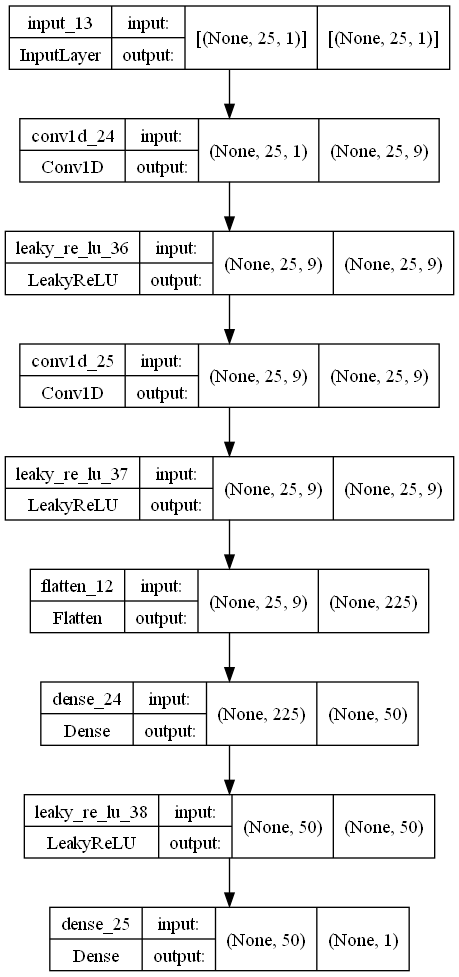

In [153]:
model0 = create_cnn()
model0.summary()

# Plot the model
plot_model(model0, show_shapes=True, show_layer_names=True)

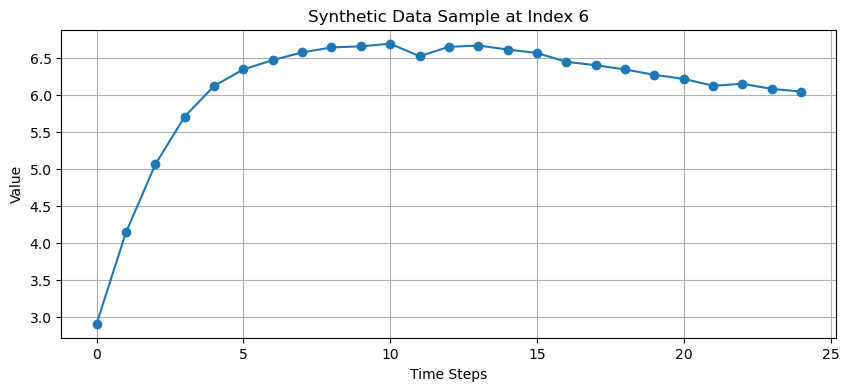

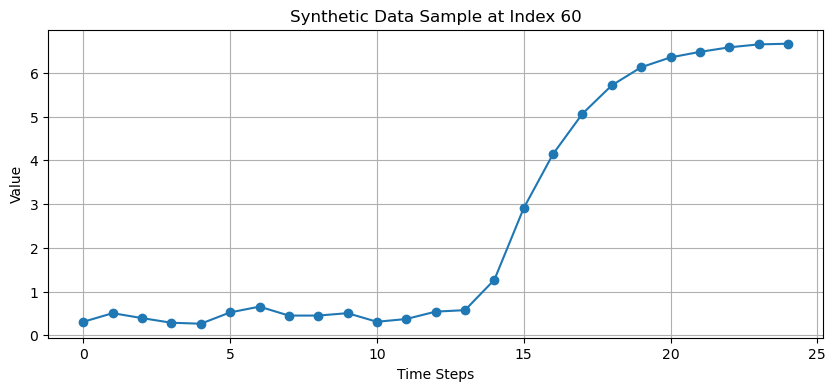

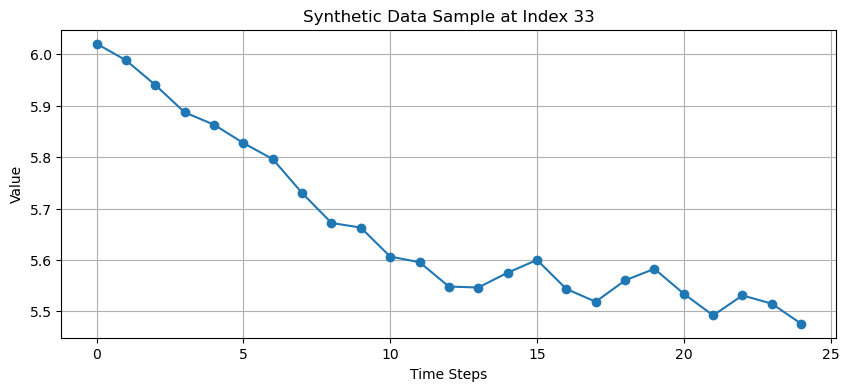

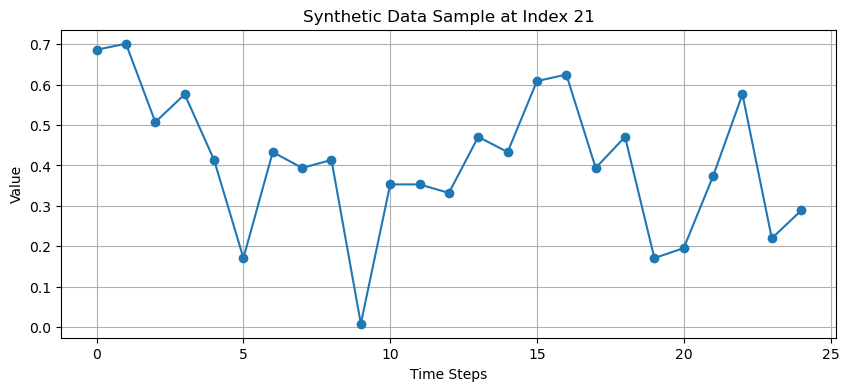

In [154]:
plot_sample(X_train, 6)
plot_sample(X_train, 60)
plot_sample(X_train, 33)
plot_sample(X_train, 21)

### before training

filter shape: (10, 1, 9)
filter shape: (10, 1, 9)
filter shape: (10, 1, 9)
filter shape: (10, 1, 9)
filter shape: (10, 1, 9)
filter shape: (10, 1, 9)
filter shape: (10, 1, 9)
filter shape: (10, 1, 9)
filter shape: (10, 1, 9)


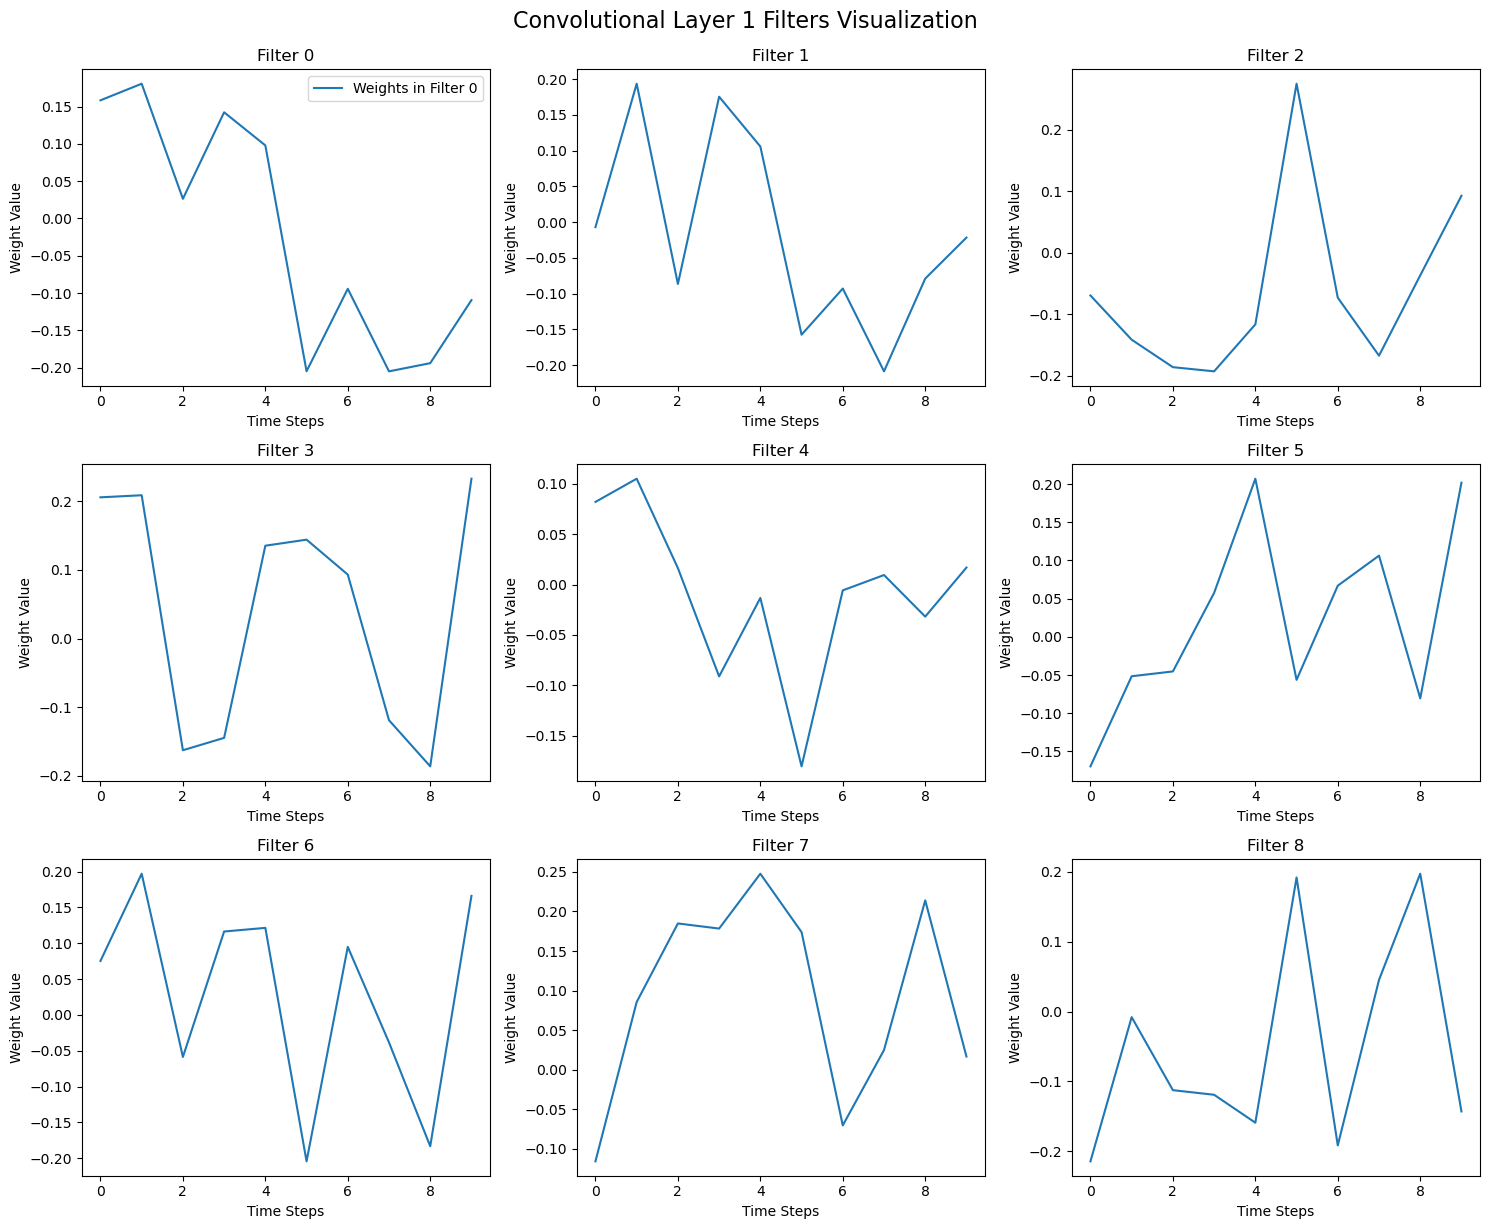

filter shape: (10, 9, 9)
filter shape: (10, 9, 9)
filter shape: (10, 9, 9)
filter shape: (10, 9, 9)
filter shape: (10, 9, 9)
filter shape: (10, 9, 9)
filter shape: (10, 9, 9)
filter shape: (10, 9, 9)
filter shape: (10, 9, 9)


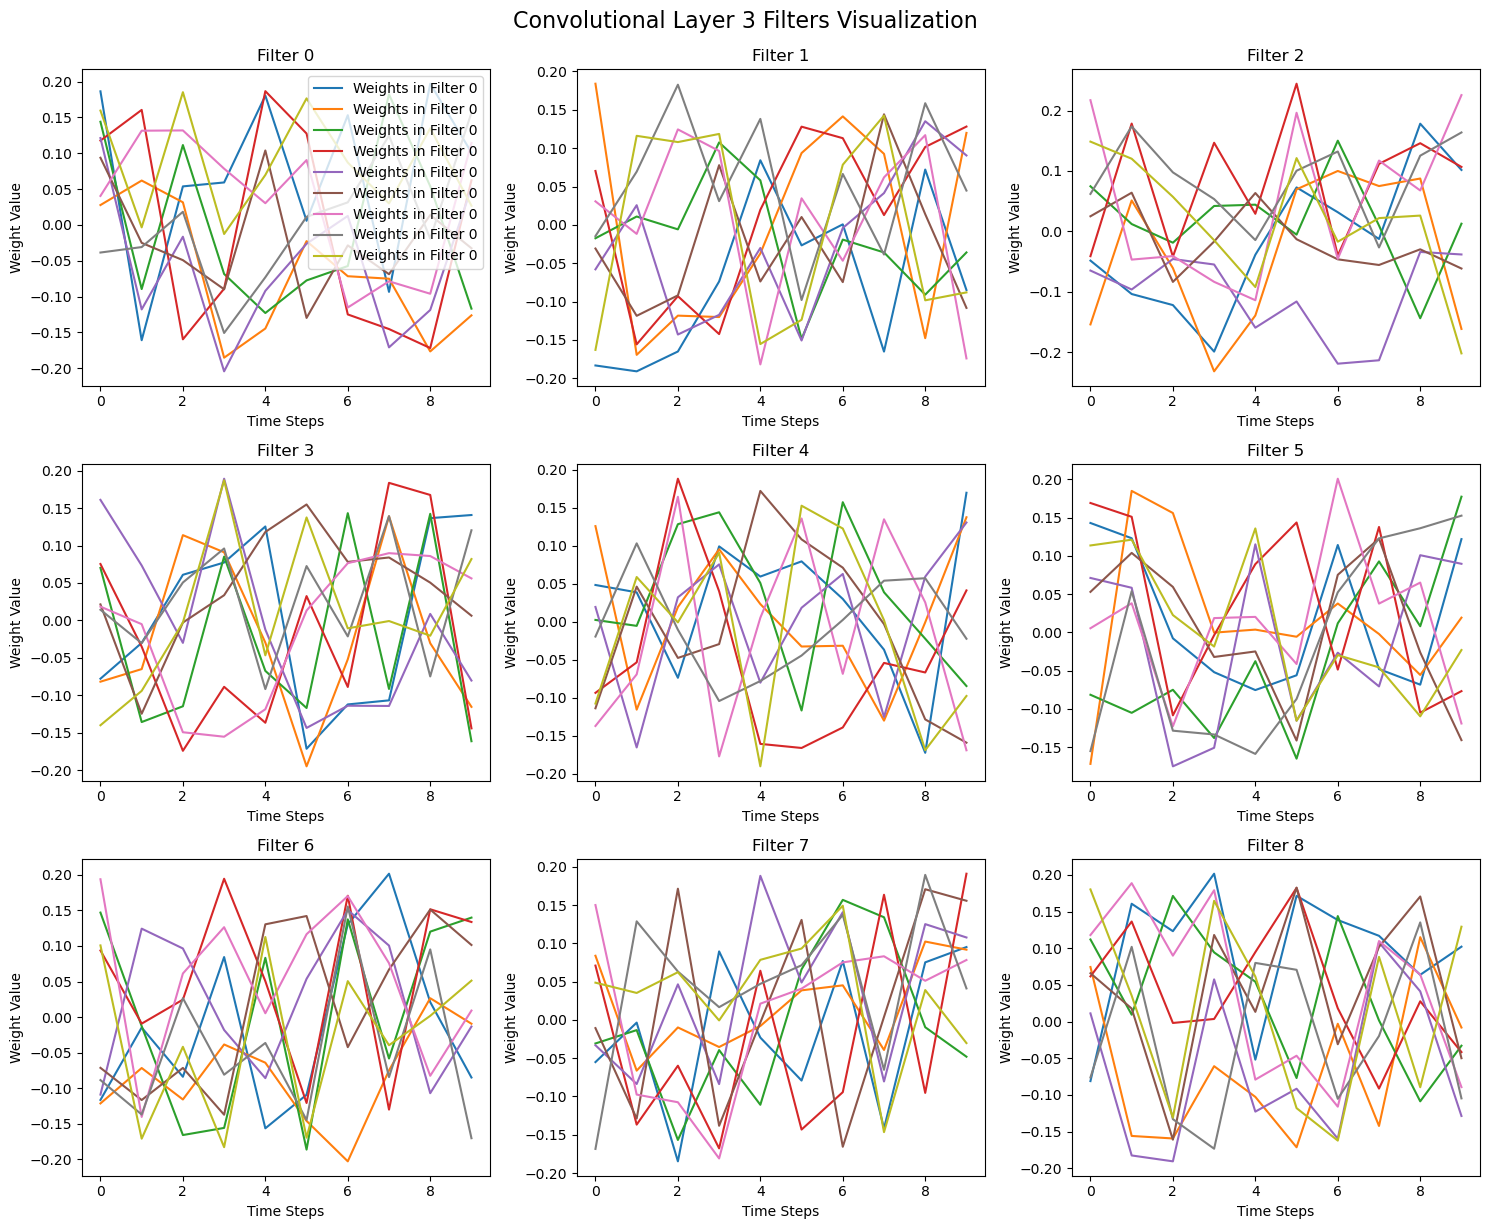

In [173]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(model0, layer_index=1)

# Plot filters of the second convolutional layer
plot_conv1d_filters(model0, layer_index=3)

Epoch 1/1000
2/2 [==============================] - 1s 190ms/step - loss: 29.5986 - val_loss: 32.0587
Epoch 2/1000
2/2 [==============================] - 0s 59ms/step - loss: 28.8952 - val_loss: 31.6582
Epoch 3/1000
2/2 [==============================] - 0s 59ms/step - loss: 28.3397 - val_loss: 31.1228
Epoch 4/1000
2/2 [==============================] - 0s 45ms/step - loss: 27.8520 - val_loss: 30.7316
Epoch 5/1000
2/2 [==============================] - 0s 56ms/step - loss: 27.5341 - val_loss: 30.3233
Epoch 6/1000
2/2 [==============================] - 0s 41ms/step - loss: 27.1129 - val_loss: 30.0050
Epoch 7/1000
2/2 [==============================] - 0s 34ms/step - loss: 26.8313 - val_loss: 29.5231
Epoch 8/1000
2/2 [==============================] - 0s 27ms/step - loss: 26.4196 - val_loss: 29.2057
Epoch 9/1000
2/2 [==============================] - 0s 31ms/step - loss: 26.0864 - val_loss: 28.7487
Epoch 10/1000
2/2 [==============================] - 0s 39ms/step - loss: 25.6146 - val_lo

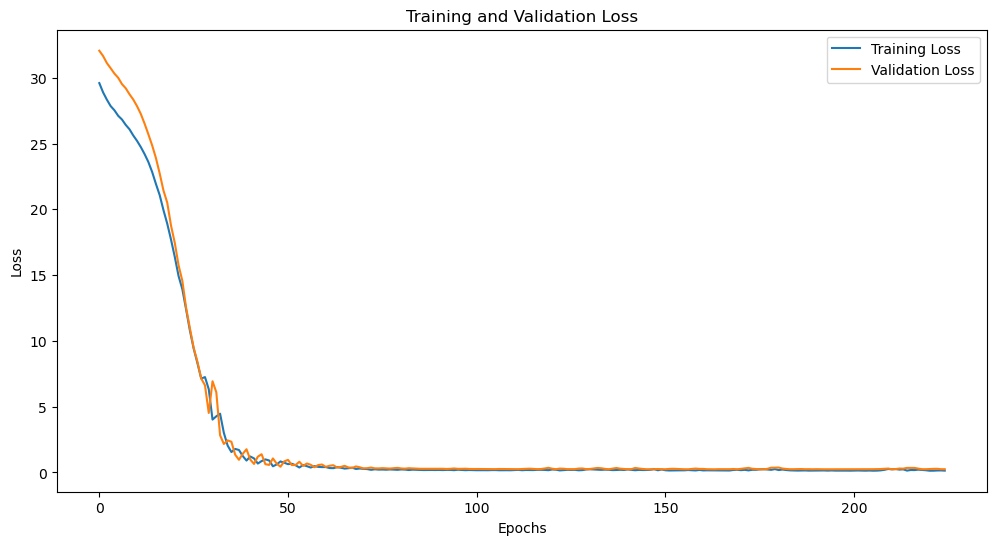

Epoch 1/200
3/3 [==============================] - 0s 7ms/step - loss: 37.3241
Epoch 2/200
3/3 [==============================] - 0s 8ms/step - loss: 32.3416
Epoch 3/200
3/3 [==============================] - 0s 6ms/step - loss: 30.3258
Epoch 4/200
3/3 [==============================] - 0s 7ms/step - loss: 29.0162
Epoch 5/200
3/3 [==============================] - 0s 5ms/step - loss: 29.3972
Epoch 6/200
3/3 [==============================] - 0s 7ms/step - loss: 28.9714
Epoch 7/200
3/3 [==============================] - 0s 7ms/step - loss: 28.2061
Epoch 8/200
3/3 [==============================] - 0s 5ms/step - loss: 27.8207
Epoch 9/200
3/3 [==============================] - 0s 8ms/step - loss: 27.6729
Epoch 10/200
3/3 [==============================] - 0s 5ms/step - loss: 27.2995
Epoch 11/200
3/3 [==============================] - 0s 5ms/step - loss: 26.8416
Epoch 12/200
3/3 [==============================] - 0s 5ms/step - loss: 26.5049
Epoch 13/200
3/3 [==============================]

In [156]:
# Set the early stopping patience and learning rate as variables
patience = 25
learning_rate = 1e-3

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

# Compile the model with the specified learning rate
model0.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Train the model with the callback
history = model0.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[early_stopping])

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Determine the optimal number of epochs from early stopping
optimal_epochs = early_stopping.stopped_epoch - patience + 1  # Adjust for the offset

# Retrain the model on the full dataset
full_X = np.concatenate((X_train, X_test))
full_y = np.concatenate((y_train, y_test))

final_model0 = create_cnn()  # Recreate the model architecture
final_model0.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')  # Compile the model just like before

# Train on the full dataset
final_model0.fit(full_X, full_y, epochs=optimal_epochs, batch_size=32, verbose=1)

### After training

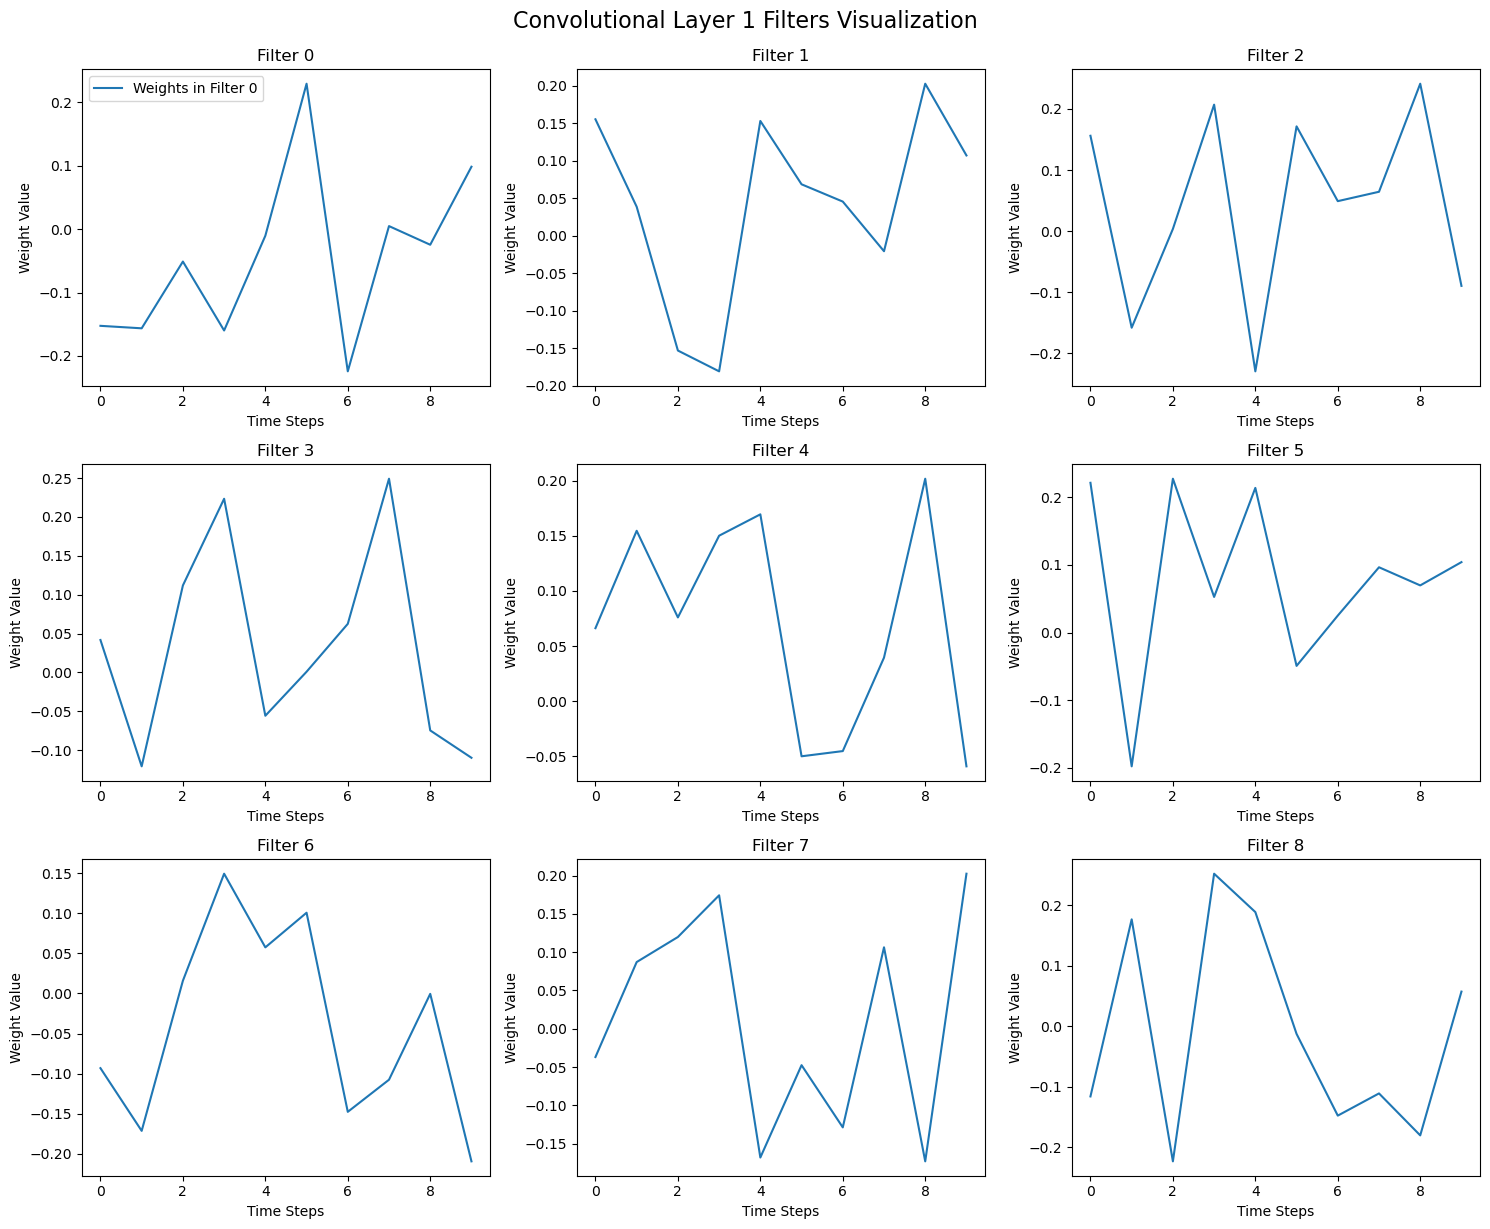

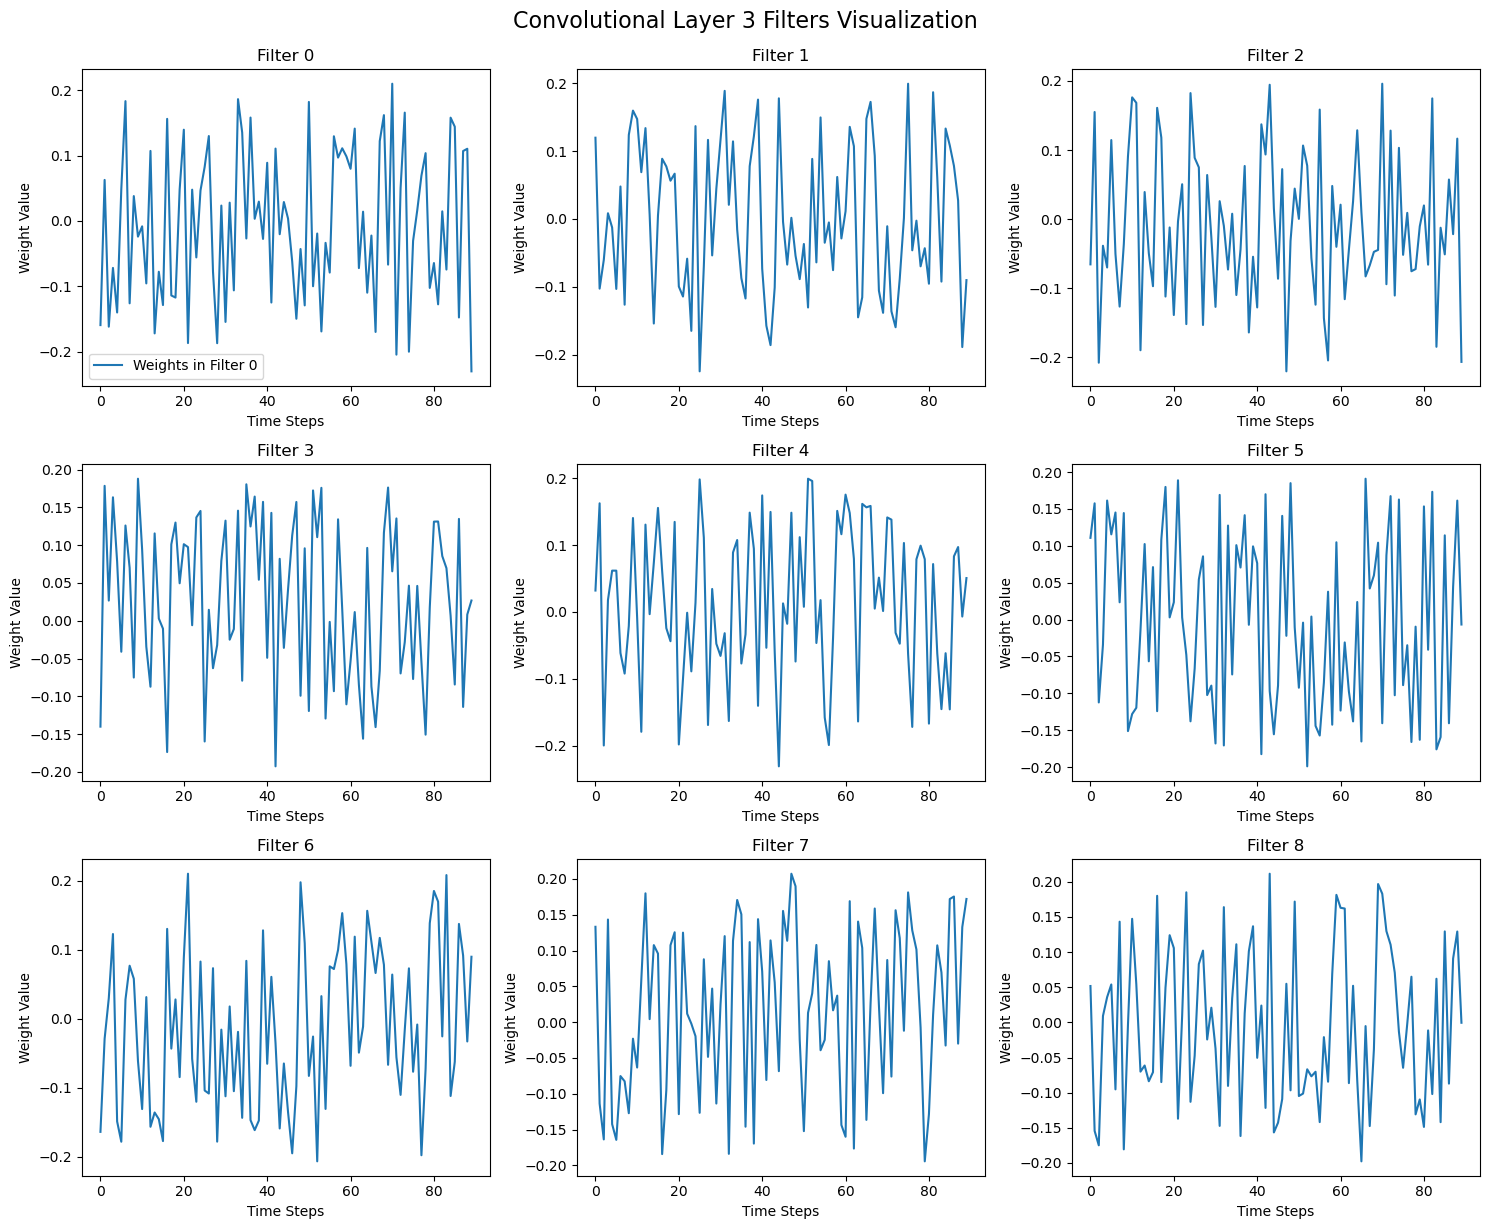

In [157]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(final_model0, layer_index=1)

# Plot filters of the second convolutional layer
plot_conv1d_filters(final_model0, layer_index=3)

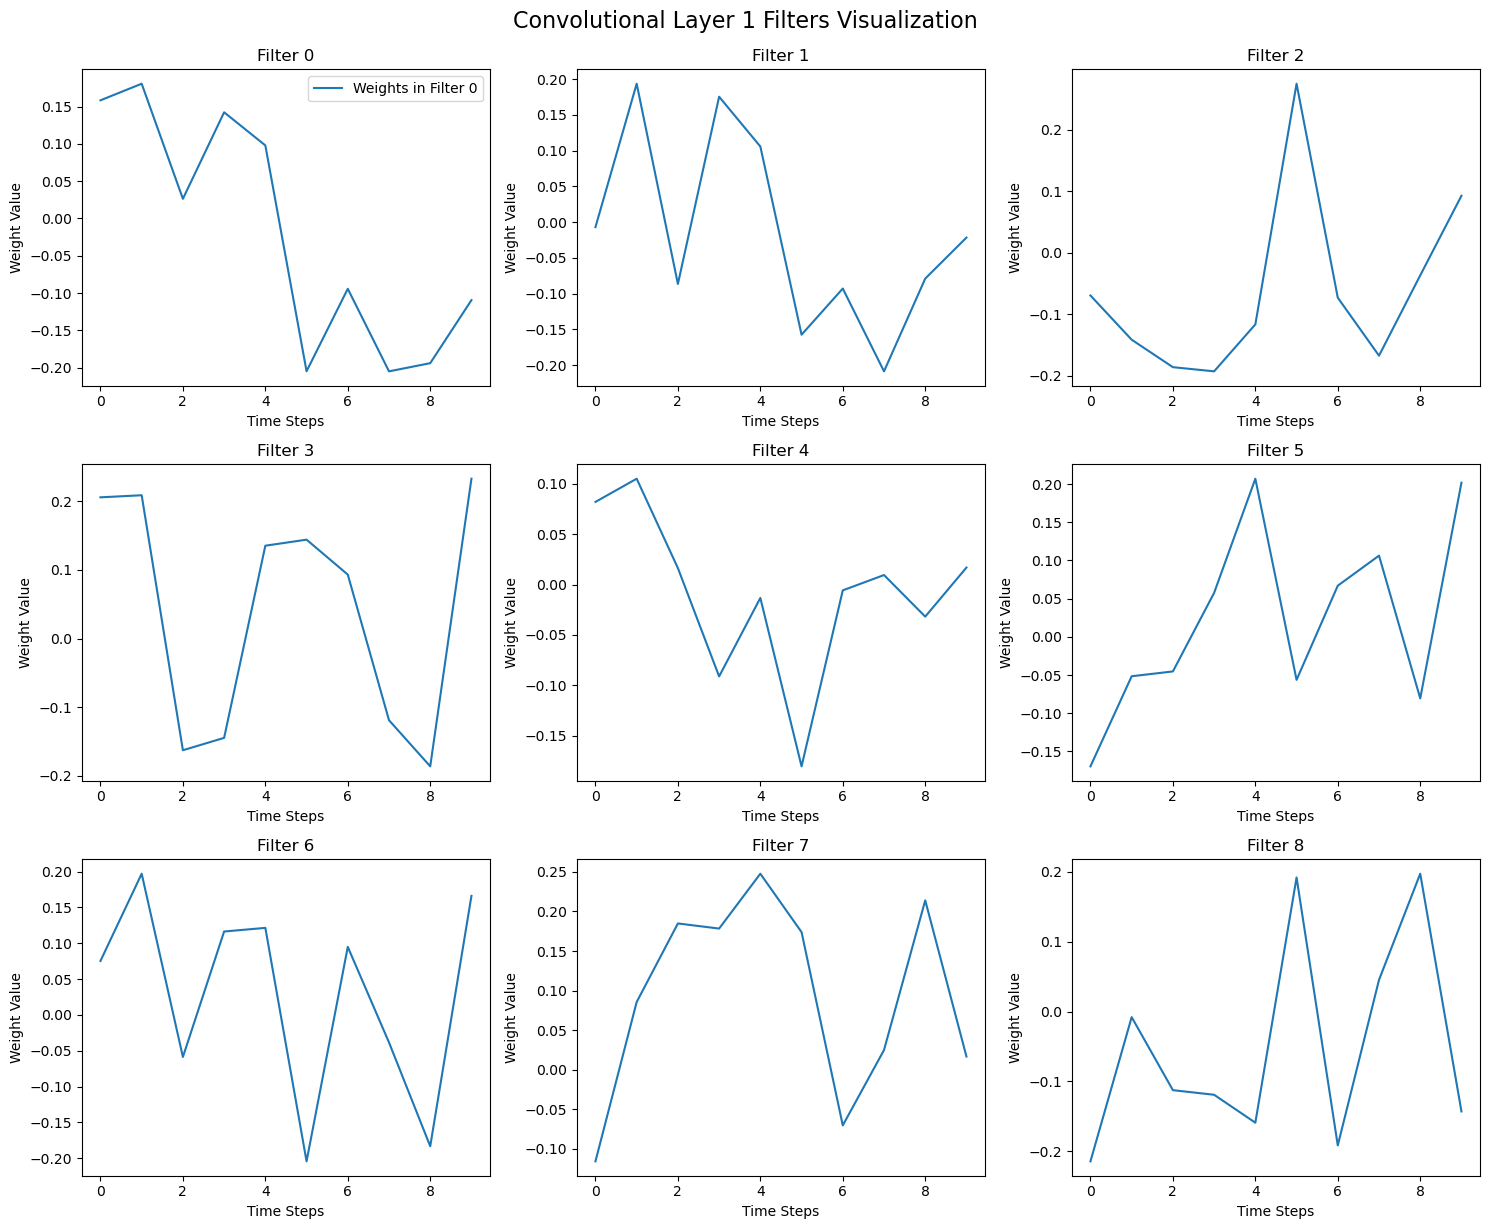

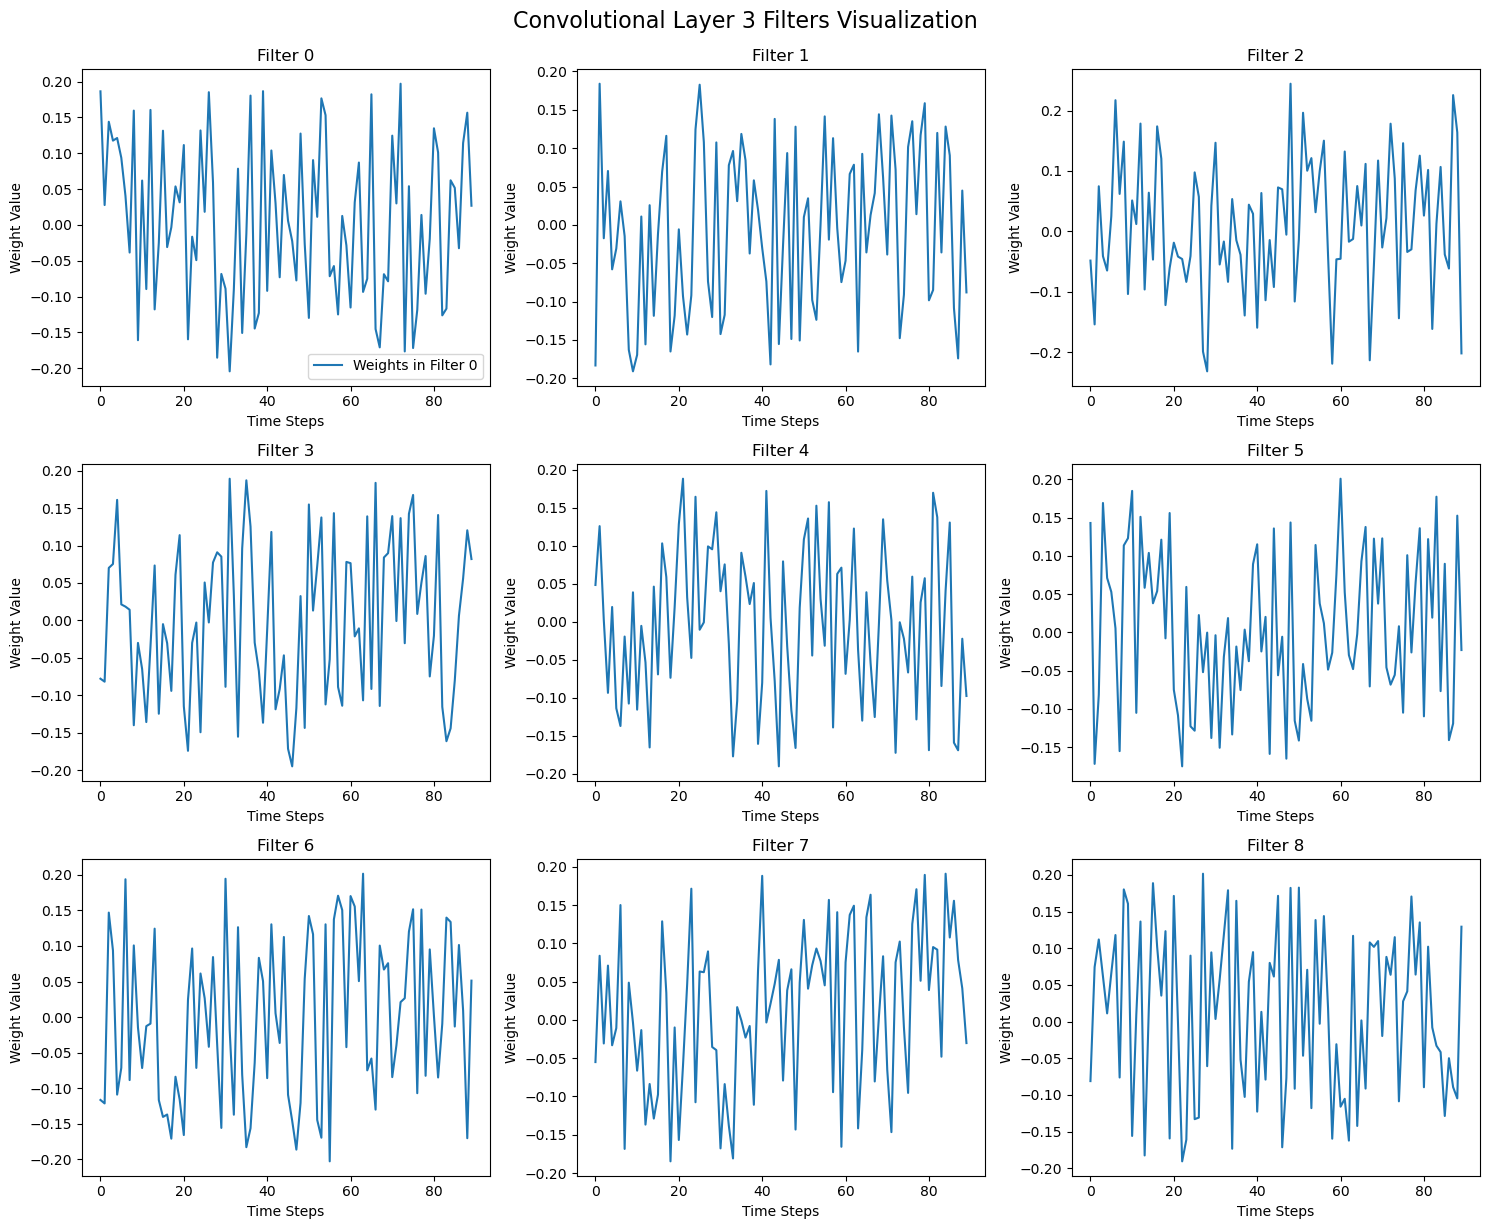

In [158]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(model0, layer_index=1)

# Plot filters of the second convolutional layer
plot_conv1d_filters(model0, layer_index=3)

## Synthetic Data for Debugging

In [188]:
model = create_cnn()
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 25, 1)]           0         
                                                                 
 conv1d_34 (Conv1D)          (None, 25, 32)            352       
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 25, 32)            0         
                                                                 
 conv1d_35 (Conv1D)          (None, 25, 32)            10272     
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 25, 32)            0         
                                                                 
 flatten_17 (Flatten)        (None, 800)               0         
                                                                 
 dense_34 (Dense)            (None, 50)                400

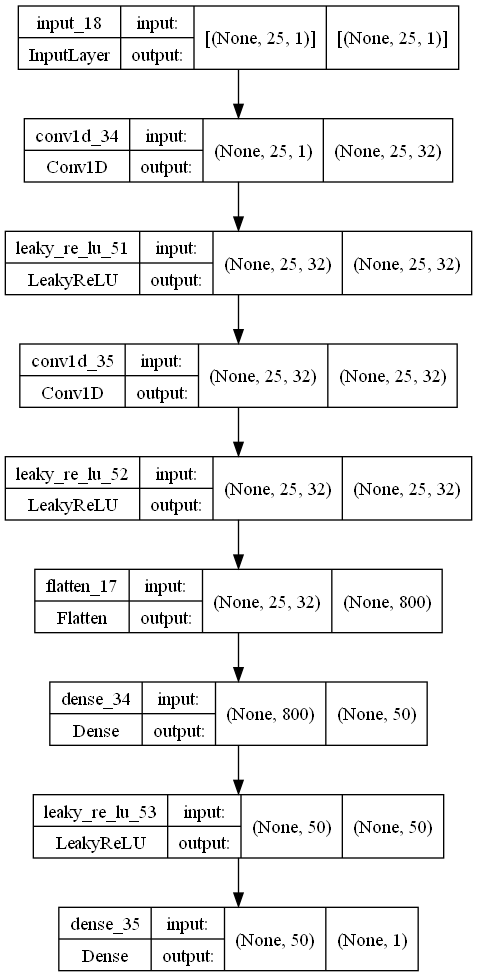

In [189]:
# Plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

In [190]:
X, y = create_synthetic_dataset()
print(X.shape)
print(y.shape)

(50000, 25, 1)
(50000, 1)


In [191]:
# Generate an array of indices
indices = np.arange(X.shape[0])
# Shuffle the indices
np.random.shuffle(indices)
# Use the shuffled indices to reorder X and y
X_shuffled = X[indices]
y_shuffled = y[indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=seed_value)

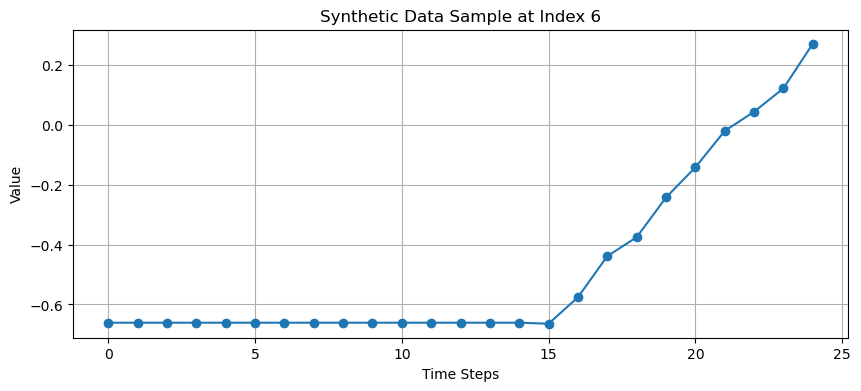

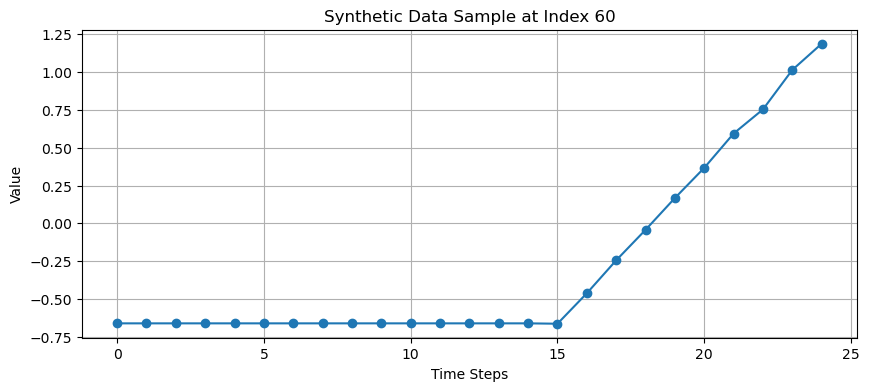

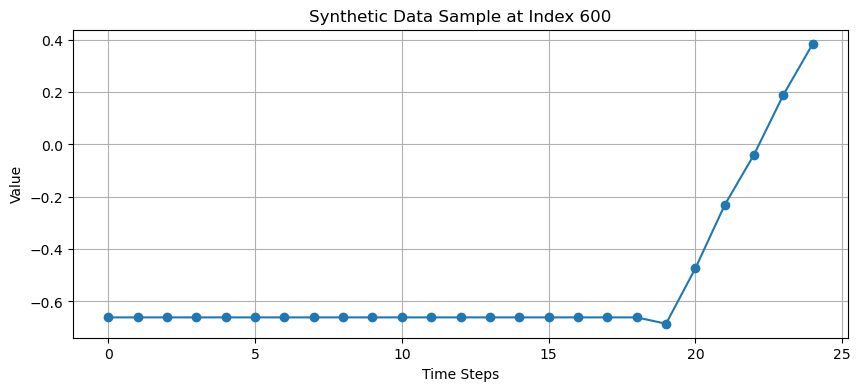

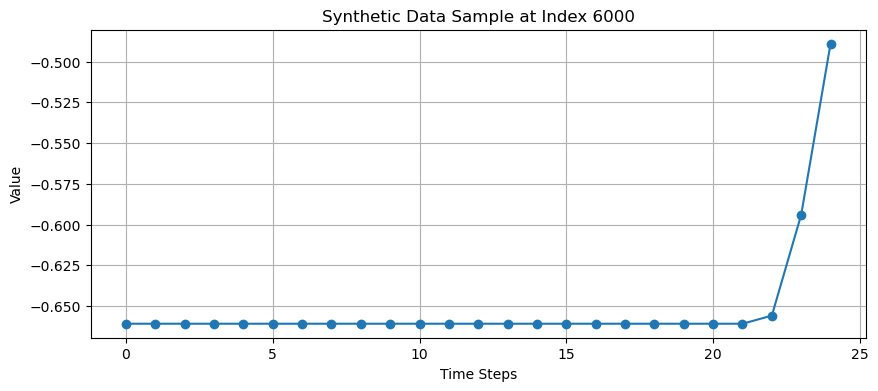

In [192]:
plot_sample(X, 6)
plot_sample(X, 60)
plot_sample(X, 600)
plot_sample(X, 6000)

### before training

filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)


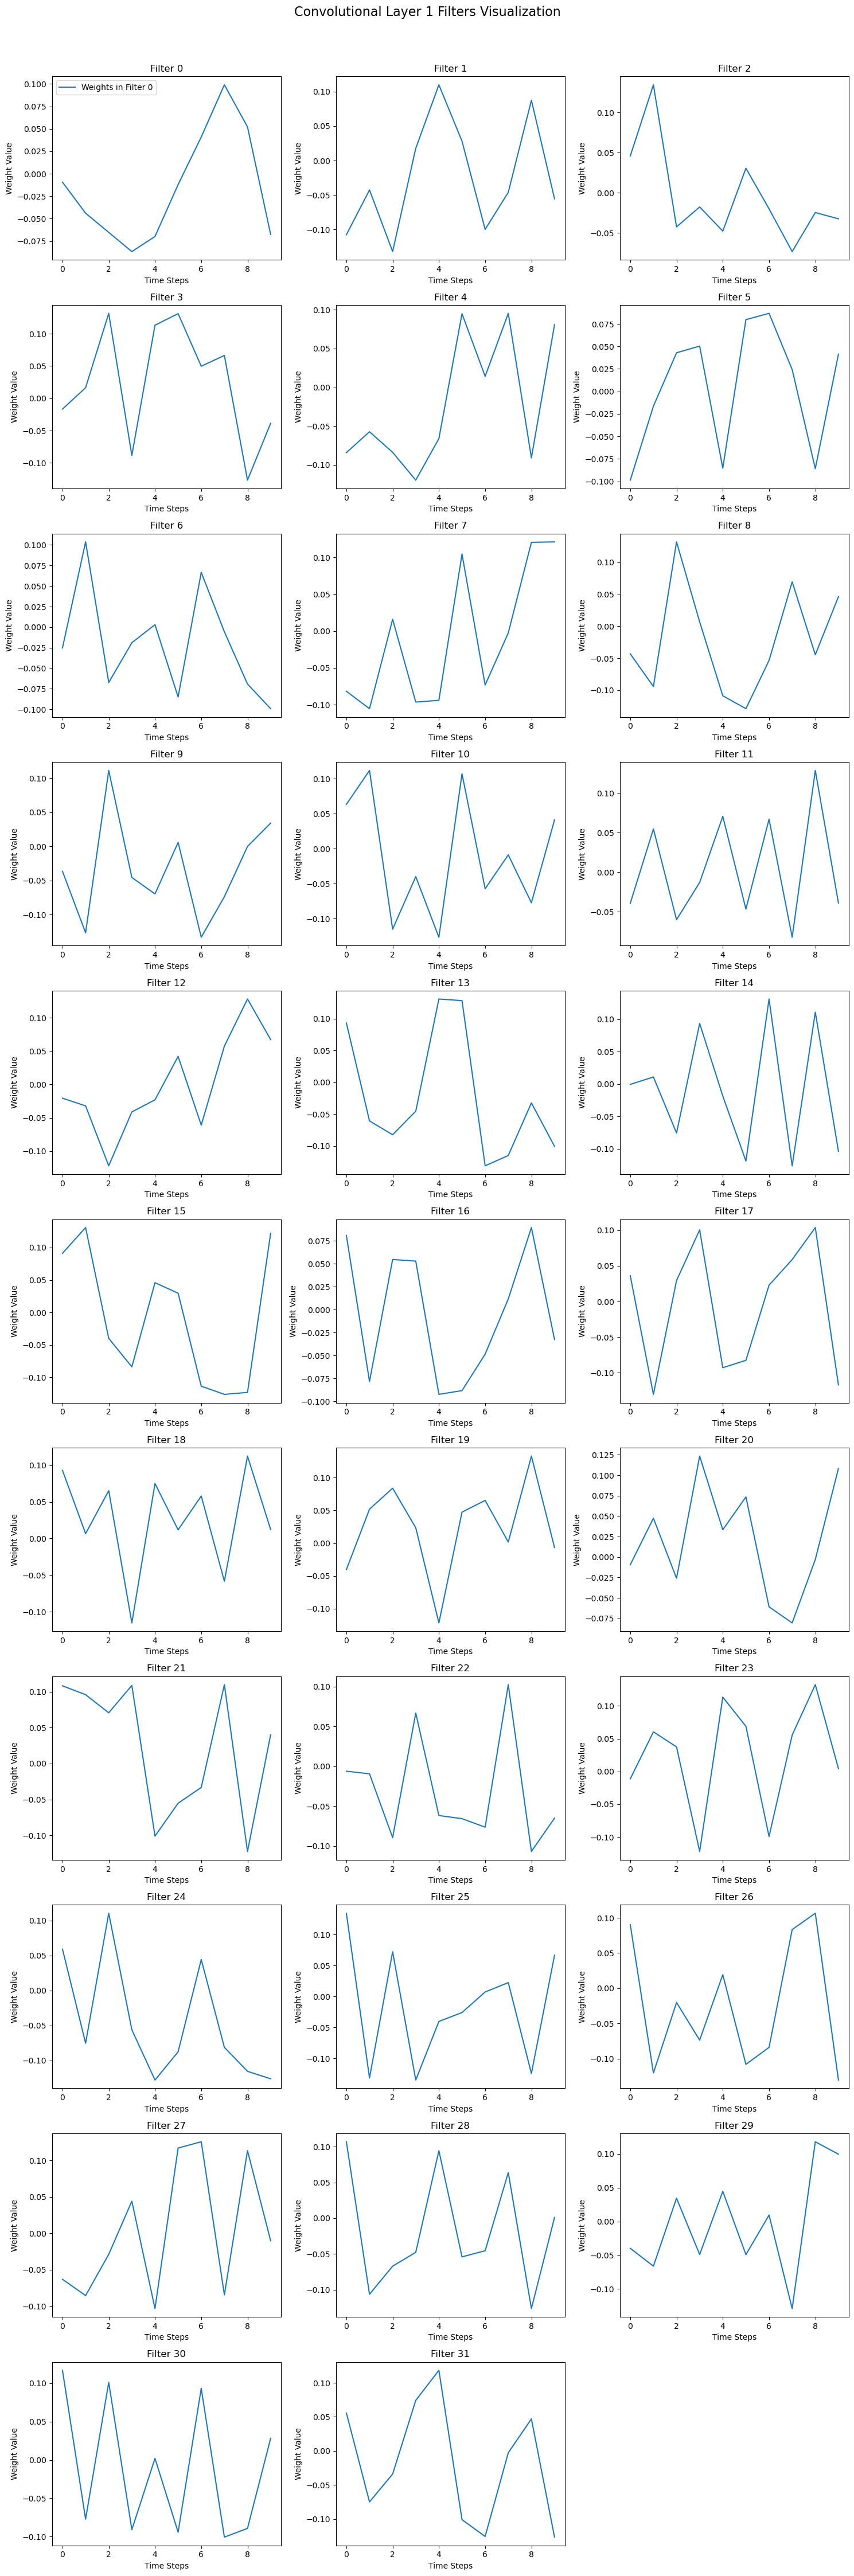

In [194]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(model, layer_index=1)

# Plot filters of the second convolutional layer
# plot_conv1d_filters(model, layer_index=3)

Epoch 1/1000
1250/1250 [==============================] - 6s 4ms/step - loss: 0.1026 - val_loss: 0.0293
Epoch 2/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0254 - val_loss: 0.0191
Epoch 3/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0225 - val_loss: 0.0150
Epoch 4/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0198 - val_loss: 0.0162
Epoch 5/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0184 - val_loss: 0.0146
Epoch 6/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0185 - val_loss: 0.0157
Epoch 7/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0172 - val_loss: 0.0125
Epoch 8/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0172 - val_loss: 0.0157
Epoch 9/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0168 - val_loss: 0.0163
Epoch 10/1000
1250/1250 [==============================] - 5s 4m

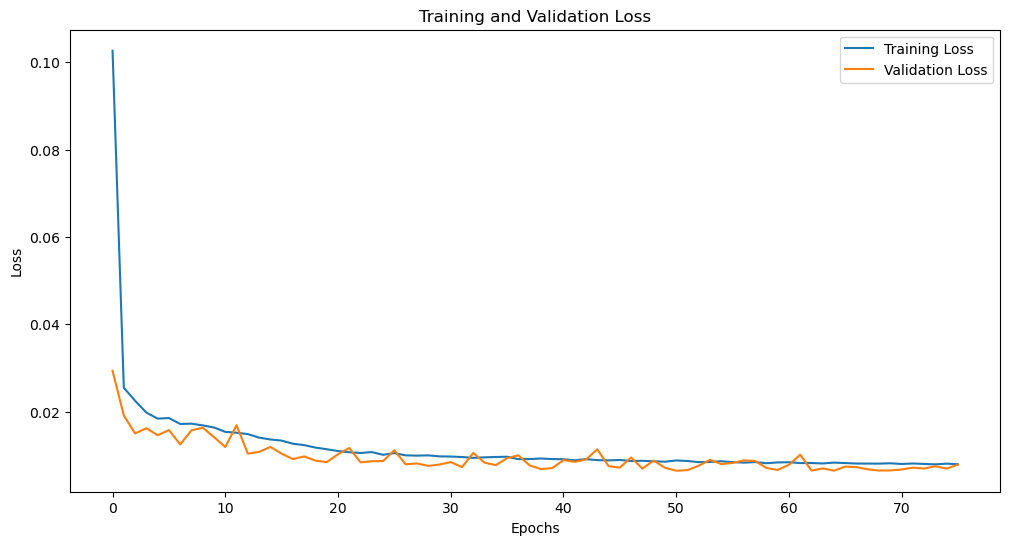

Epoch 1/51
1563/1563 [==============================] - 8s 4ms/step - loss: 0.1016
Epoch 2/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0246
Epoch 3/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0204
Epoch 4/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0194
Epoch 5/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0179
Epoch 6/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0173
Epoch 7/51
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0165
Epoch 8/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0159
Epoch 9/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0152
Epoch 10/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0139
Epoch 11/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0141
Epoch 12/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0128
E

In [195]:
# Set the early stopping patience and learning rate as variables
patience = 25
learning_rate = 1e-3

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

# Compile the model with the specified learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Train the model with the callback
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Determine the optimal number of epochs from early stopping
optimal_epochs = early_stopping.stopped_epoch - patience + 1  # Adjust for the offset

# Retrain the model on the full dataset
full_X = np.concatenate((X_train, X_test))
full_y = np.concatenate((y_train, y_test))

final_model = create_cnn()  # Recreate the model architecture
final_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')  # Compile the model just like before

# Train on the full dataset
final_model.fit(full_X, full_y, epochs=optimal_epochs, batch_size=32, verbose=1)

### After training

filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)


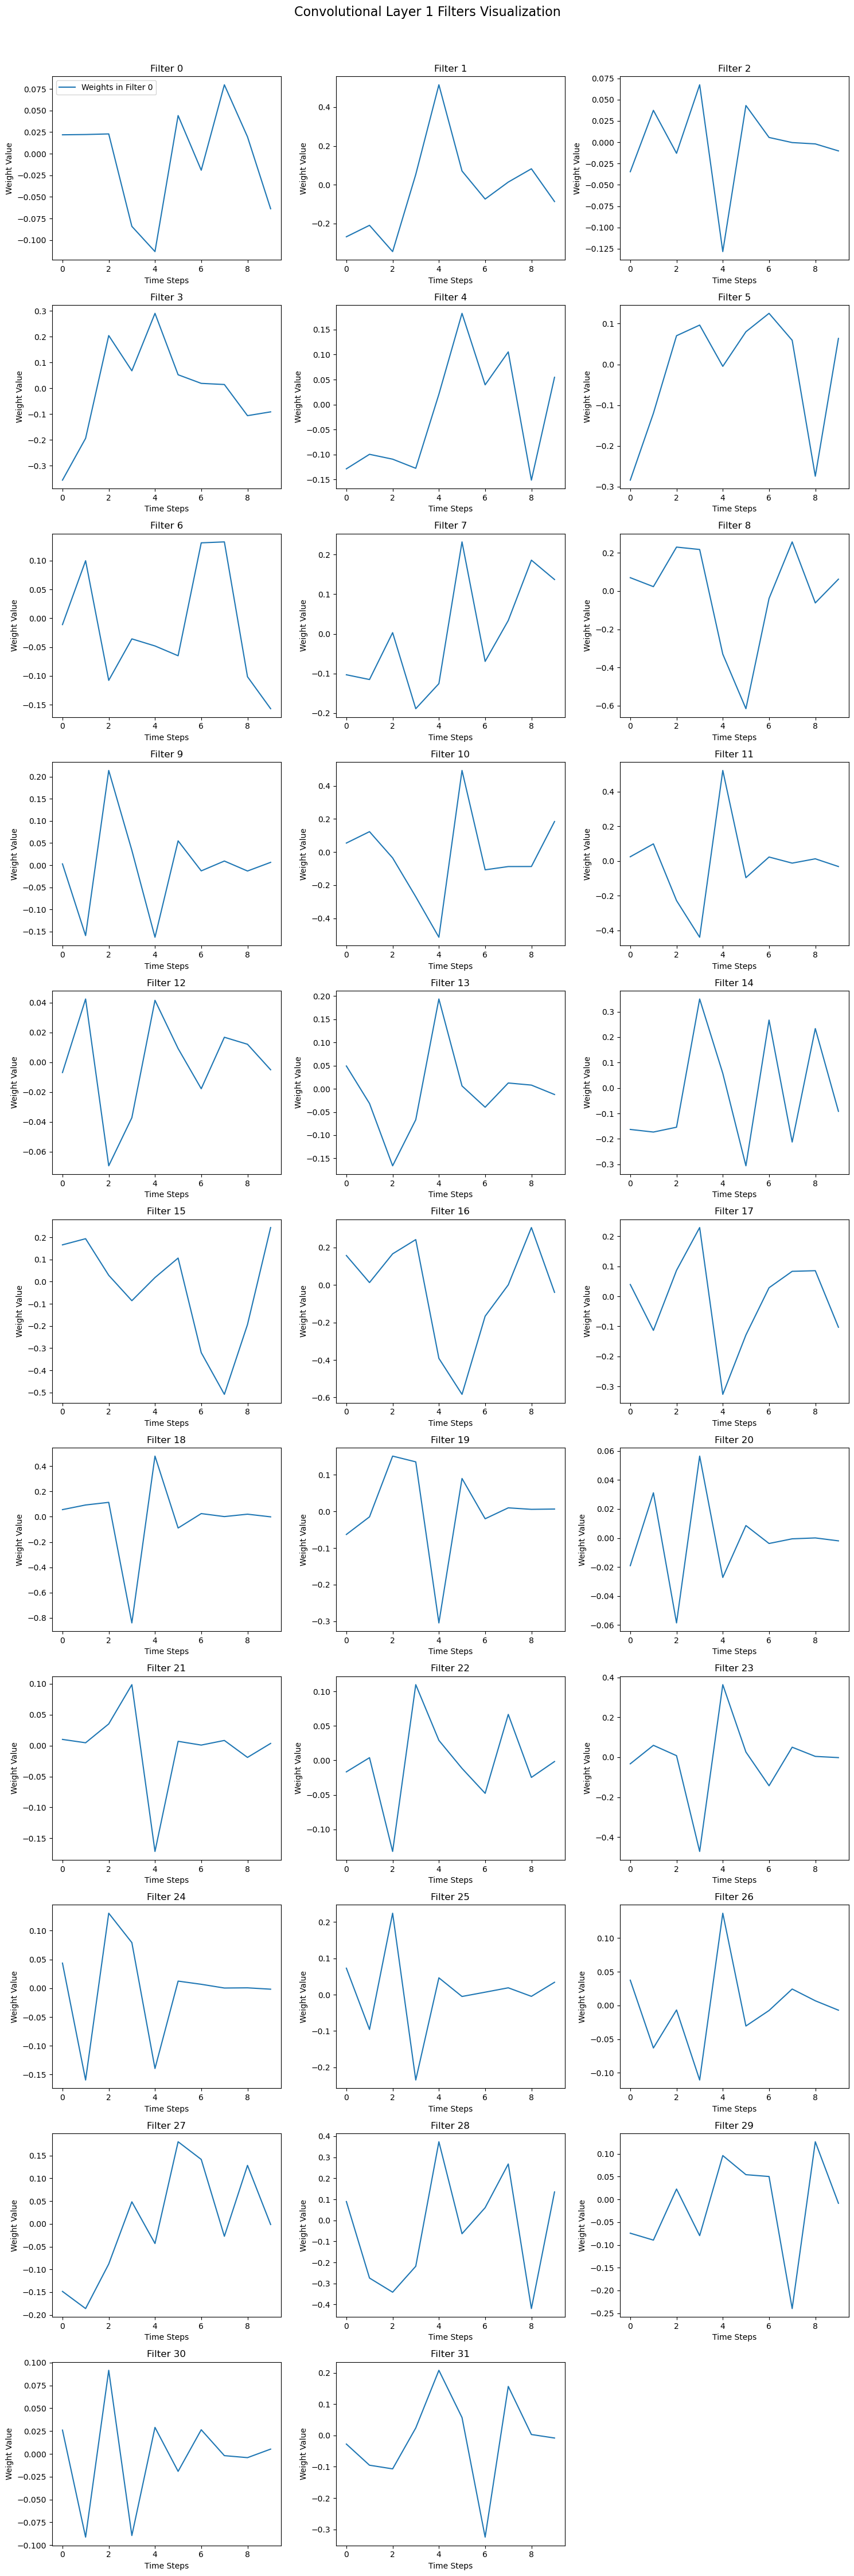

In [196]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(model, layer_index=1)

# Plot filters of the second convolutional layer
# plot_conv1d_filters(model, layer_index=3)

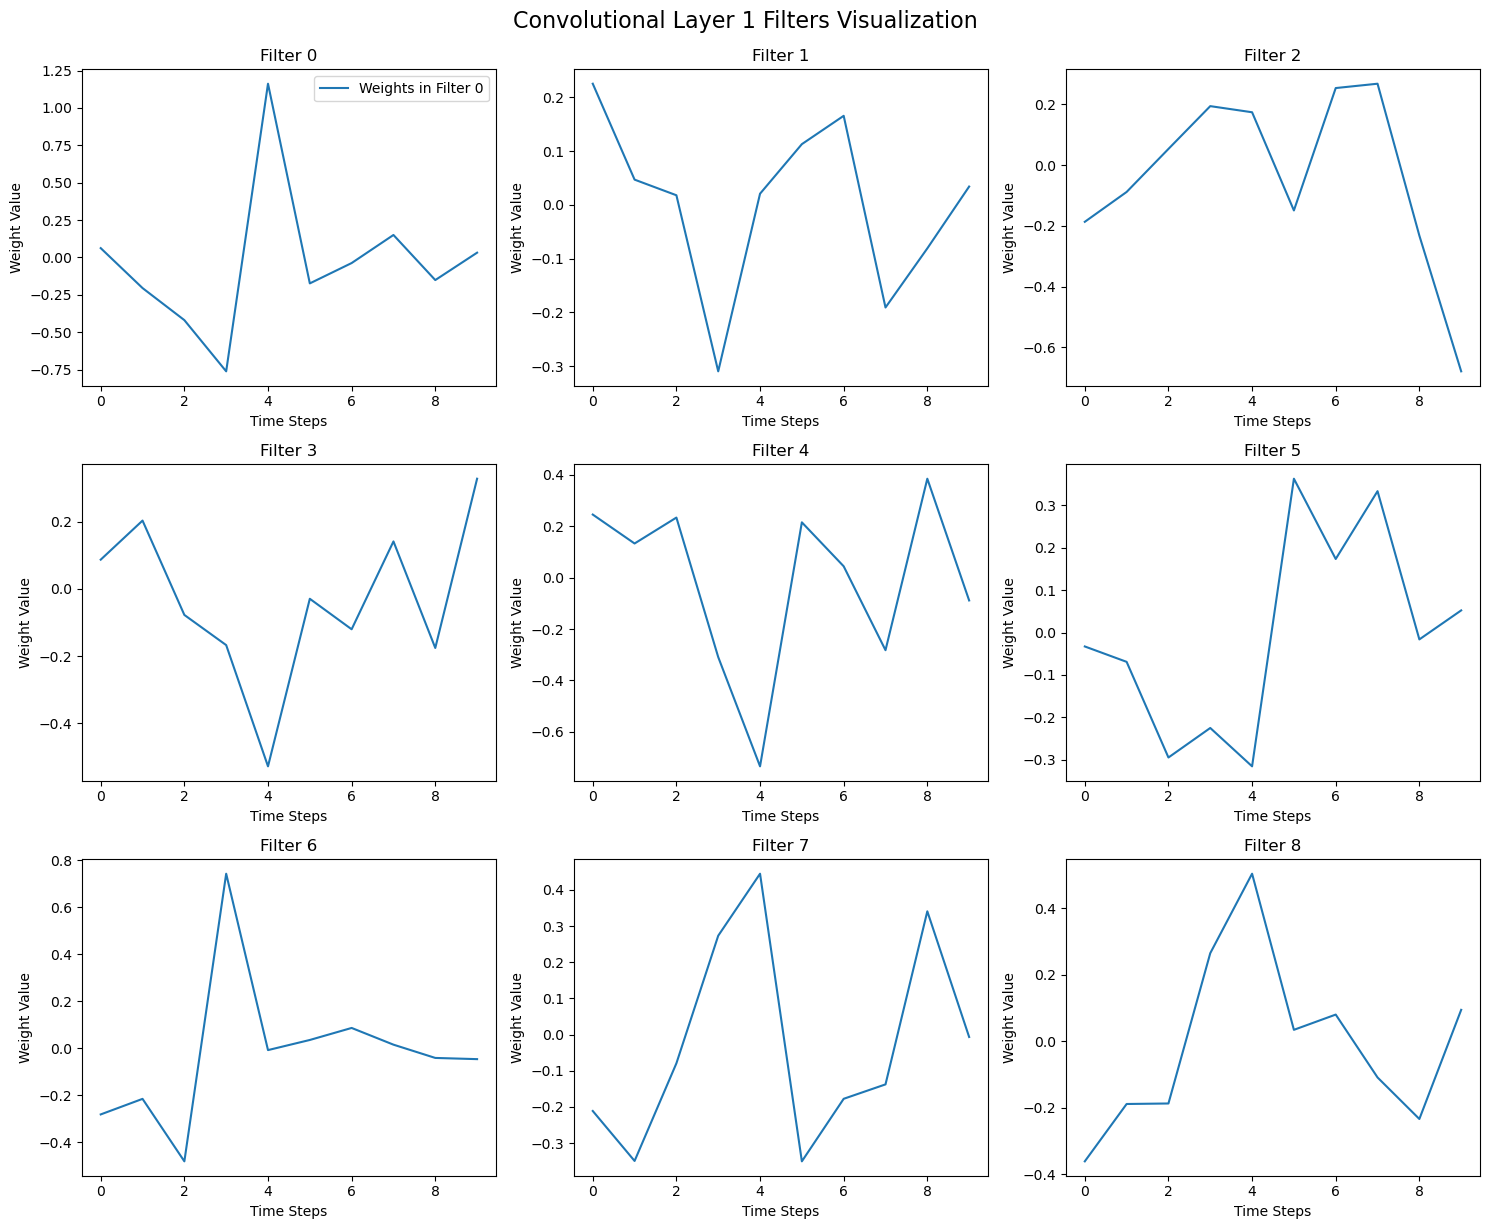

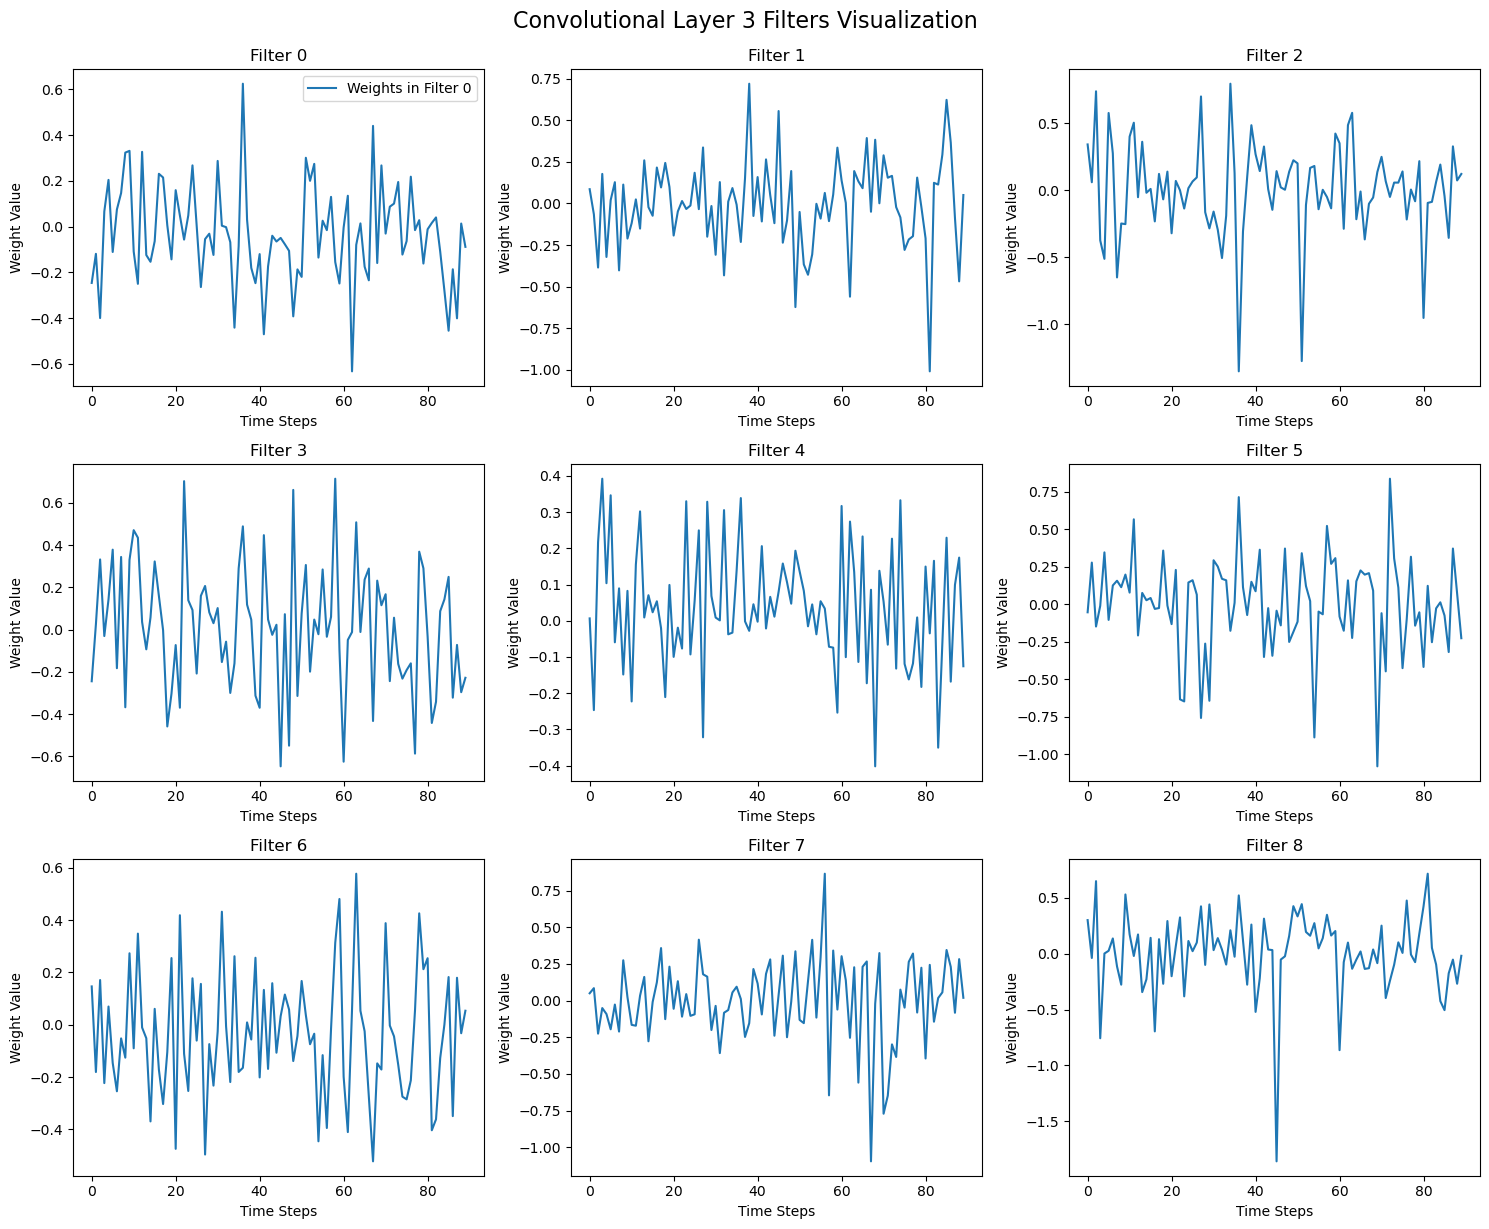

In [169]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(final_model, layer_index=1)

# Plot filters of the second convolutional layer
plot_conv1d_filters(final_model, layer_index=3)

In [118]:
X_testing, y_testing = create_synthetic_dataset(n_samples=10000)
print(X_testing.shape)
print(y_testing.shape)


(10000, 25, 1)
(10000, 1)


In [119]:
error = evaluate_model(final_model, X_test, y_test)
print(f'mae error: {error}')

mae error: 0.04408179751281459


# more SEP data once cleaned up

In [14]:
X_train, y_train = build_dataset('D:/College/Fall2023/electron_cme_data_split/training')
X_subtrain, y_subtrain = build_dataset('D:/College/Fall2023/electron_cme_data_split/subtraining')
X_test, y_test = build_dataset('D:/College/Fall2023/electron_cme_data_split/testing')
X_val, y_val = build_dataset('D:/College/Fall2023/electron_cme_data_split/validation')

In [15]:
# print all data shapes 
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')


X_train.shape: (10971, 25, 1)
y_train.shape: (10971,)
X_subtrain.shape: (7301, 25, 1)
y_subtrain.shape: (7301,)
X_test.shape: (7842, 25, 1)
y_test.shape: (7842,)
X_val.shape: (3670, 25, 1)
y_val.shape: (3670,)


In [16]:
# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

X_train[0]: [[0.87270187]
 [0.87506487]
 [0.8789223 ]
 [0.87294049]
 [0.87377044]
 [0.87371155]
 [0.87903635]
 [0.877898  ]
 [0.87311852]
 [0.87180353]
 [0.87252292]
 [0.87388908]
 [0.87657614]
 [0.87982637]
 [0.88155799]
 [0.88353927]
 [0.88353927]
 [0.88154728]
 [0.88121404]
 [0.88153765]
 [0.8809816 ]
 [0.87873179]
 [0.87602744]
 [0.87247607]
 [0.87030833]]
y_train[0]: 1.572317392330659


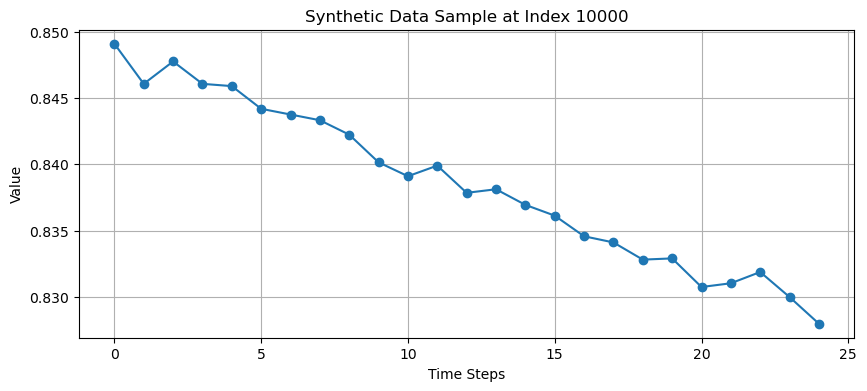

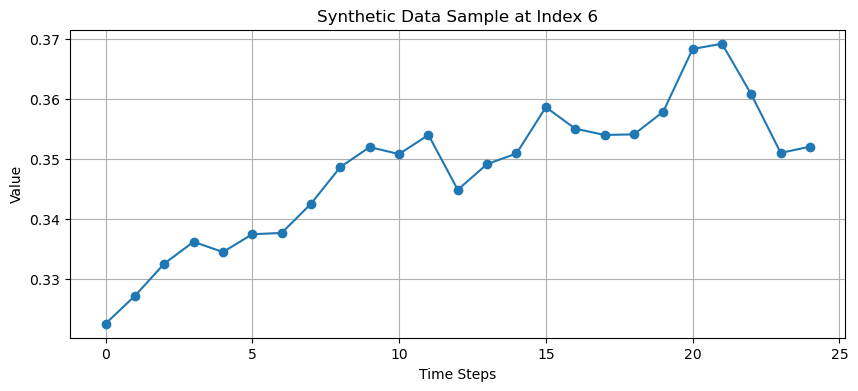

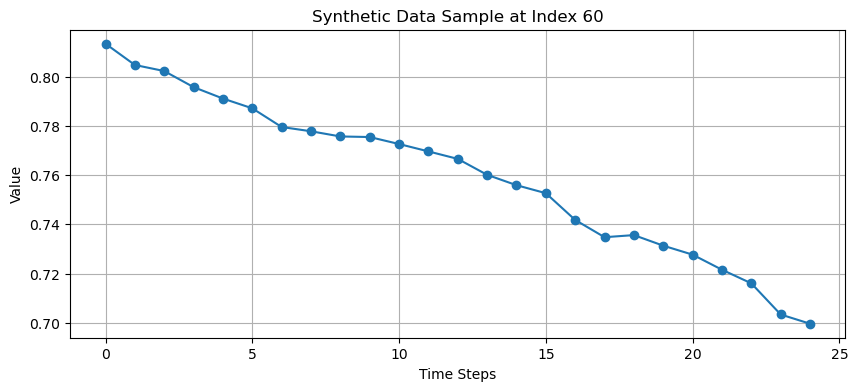

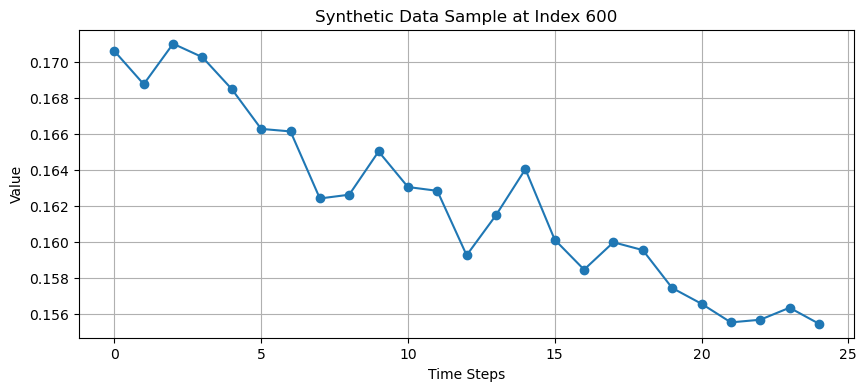

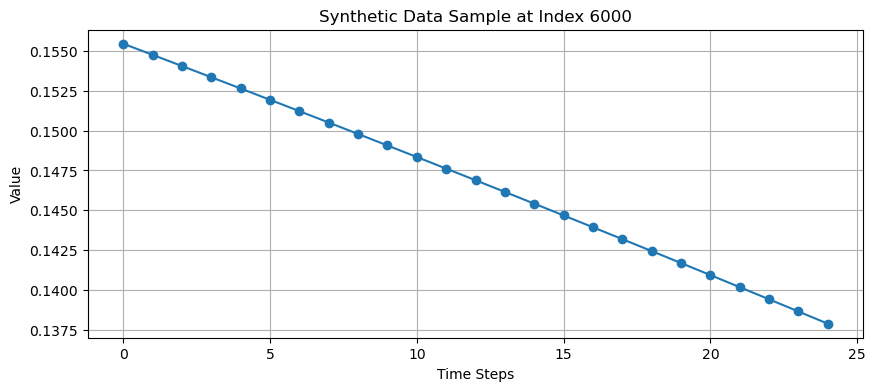

In [17]:
# plot a training sample 
plot_sample(X_train, 10000)
plot_sample(X_train, 6)
plot_sample(X_train, 60)
plot_sample(X_train, 600)
plot_sample(X_train, 6000)

In [18]:
# create the model 
model_sep = create_cnn()
model_sep.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 25, 32)            352       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            10272     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 25, 32)            0         
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 50)                40050 

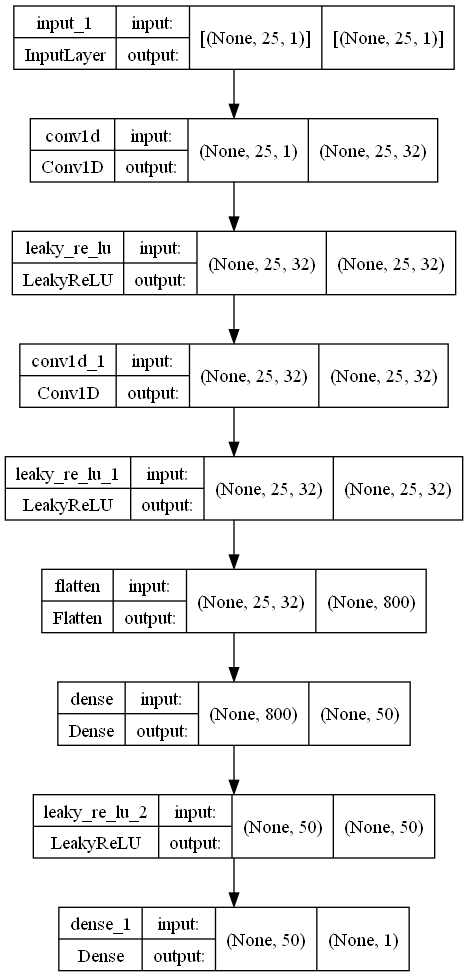

In [19]:
# Plot the model
plot_model(model_sep, show_shapes=True, show_layer_names=True)

### before training

filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)


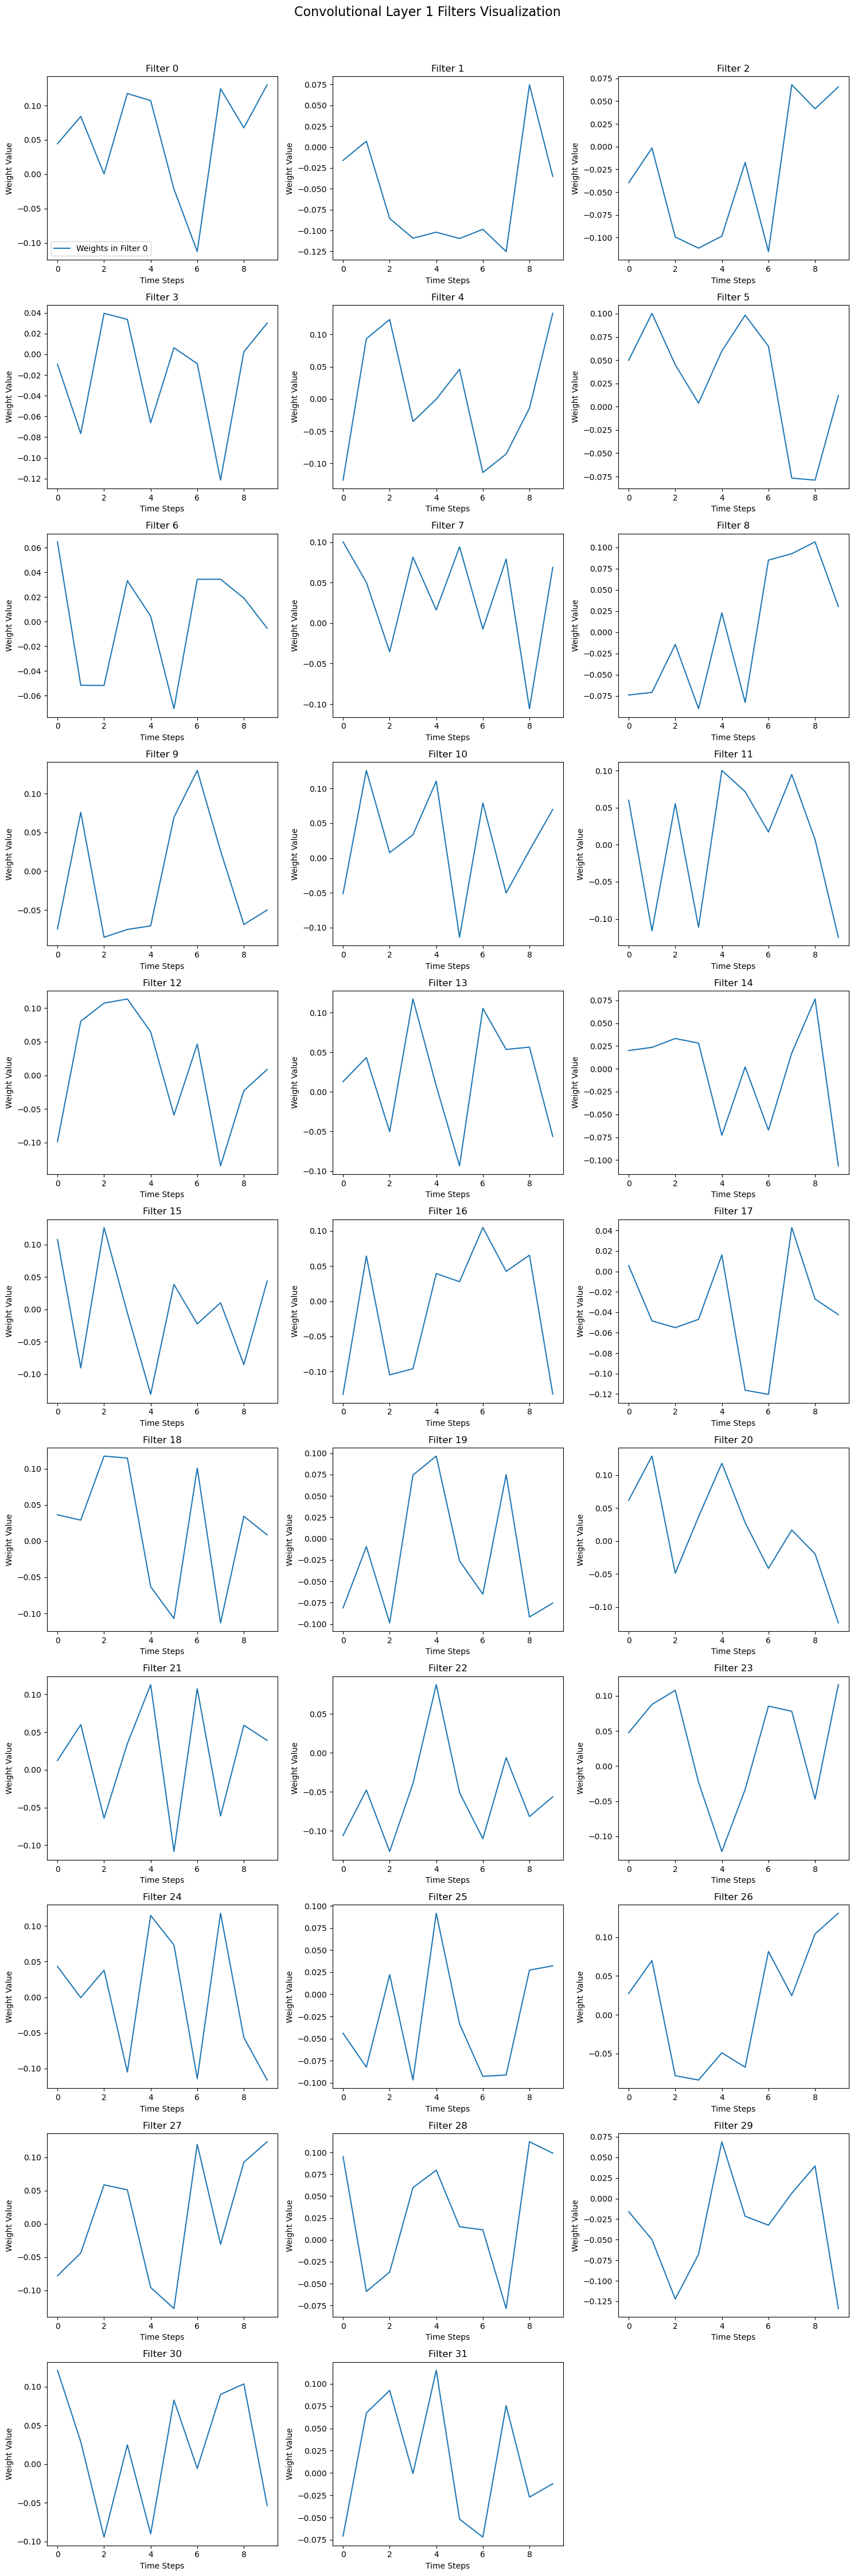

In [20]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(model_sep, layer_index=1)

Epoch 1/1000
229/229 [==============================] - 2s 7ms/step - loss: 0.7301 - val_loss: 1.1544
Epoch 2/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.7368 - val_loss: 1.3161
Epoch 3/1000
229/229 [==============================] - 1s 5ms/step - loss: 0.7145 - val_loss: 1.3704
Epoch 4/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.7184 - val_loss: 1.6538
Epoch 5/1000
229/229 [==============================] - 1s 5ms/step - loss: 0.7144 - val_loss: 1.4866
Epoch 6/1000
229/229 [==============================] - 1s 5ms/step - loss: 0.7096 - val_loss: 1.4218
Epoch 7/1000
229/229 [==============================] - 1s 5ms/step - loss: 0.7092 - val_loss: 1.7439
Epoch 8/1000
229/229 [==============================] - 1s 5ms/step - loss: 0.7055 - val_loss: 1.7644
Epoch 9/1000
229/229 [==============================] - 1s 6ms/step - loss: 0.7081 - val_loss: 1.5800
Epoch 10/1000
229/229 [==============================] - 1s 5ms/step - loss: 0.701

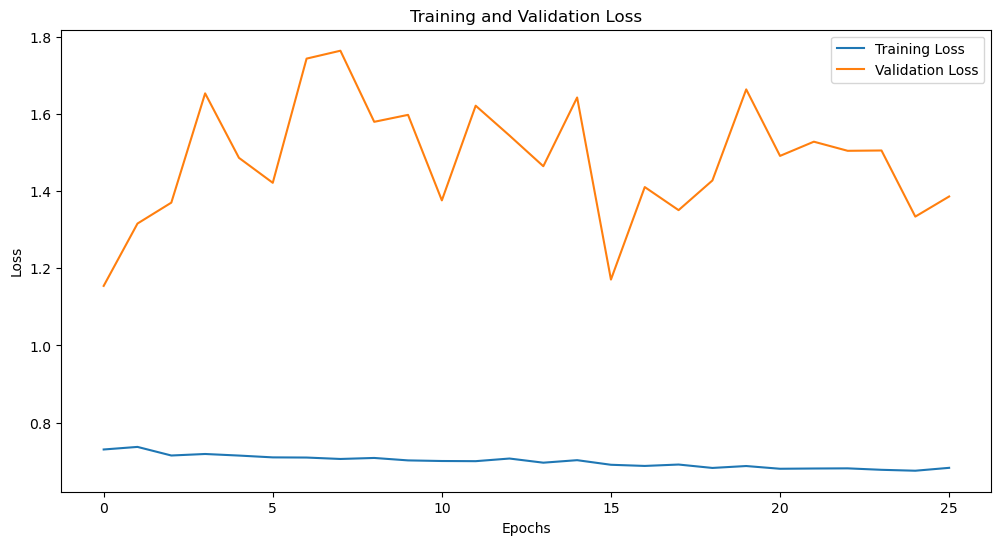

343/343 [==============================] - 2s 4ms/step - loss: 0.9785


In [49]:
# Set the early stopping patience and learning rate as variables
patience = 25
learning_rate = 3e-3

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

# Compile the model with the specified learning rate
model_sep.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Train the model with the callback
history = model_sep.fit(X_subtrain, y_subtrain, epochs=1000, batch_size=32, validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Determine the optimal number of epochs from early stopping
optimal_epochs = early_stopping.stopped_epoch - patience + 1  # Adjust for the offset
final_model_sep = create_cnn()  # Recreate the model architecture
final_model_sep.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')  # Compile the model just like before
# Train on the full dataset
final_model_sep.fit(X_train, y_train, epochs=optimal_epochs, batch_size=32, verbose=1)

### After training

filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)


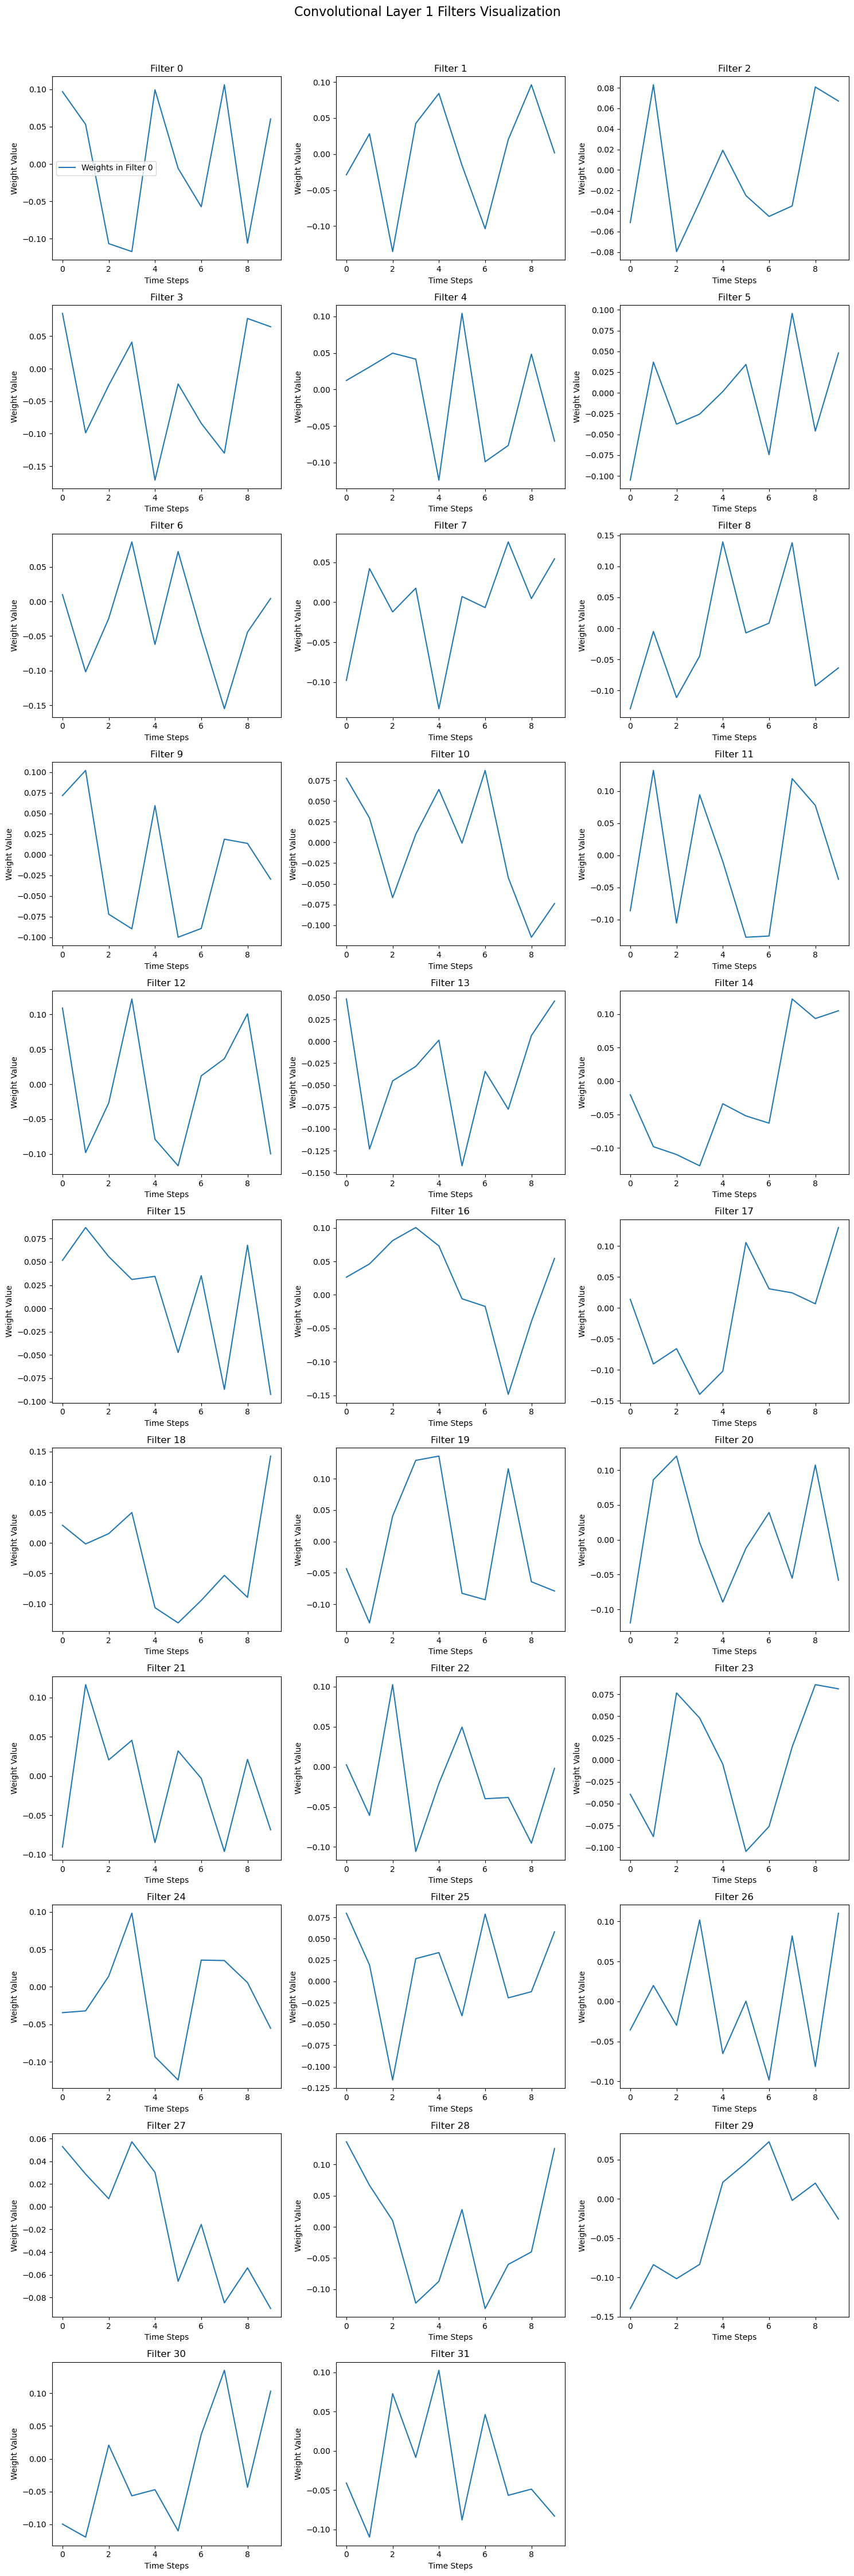

In [50]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(final_model_sep, layer_index=1)

In [51]:
# evaluate the model on test data
error_mae = evaluate_model(final_model_sep, X_test, y_test)
print(f'mae error: {error_mae}')

mae error: 0.6444607019006181


In [55]:
# plot the actual vs predicted
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import Tuple, Any, List


def read_sep_data(file_path: str) -> pd.DataFrame:
    """
    Reads the SEP event data from a CSV file.
    
    Parameters:
    - file_path (str): The path to the SEP event CSV file.
    
    Returns:
    - DataFrame: The SEP event data as a pandas DataFrame.
    """
    return pd.read_csv(file_path)


def normalize_flux(df: pd.DataFrame, columns: List[str], apply_log: bool = True) -> pd.DataFrame:
    """
    Normalizes the specified flux intensity columns in the DataFrame between 0 and 1.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the SEP event data.
    - columns (List[str]): A list of column names to be normalized.
    - apply_log (bool): Whether to apply a logarithmic transformation. Default is True.
    
    Returns:
    - DataFrame: The DataFrame with the normalized columns.
    """
    for column in columns:
        if apply_log:
            # Apply a logarithmic transformation before normalization
            df[column] = np.log(df[column] + 1)  # Adding 1 to avoid log(0)
        min_val = df[column].min()
        max_val = df[column].max()
        df[column] = (df[column] - min_val) / (max_val - min_val)
    return df

def extract_cme_start_times(df: pd.DataFrame) -> List[pd.Timestamp]:
    """
    Extracts CME start times from the 'cme_donki_time' column.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the SEP event data.
    
    Returns:
    - List[pd.Timestamp]: A list of CME start times.
    """
    valid_times = []
    for time in df['cme_donki_time']:
        if time != 0:  # Exclude zero values which are placeholders
            try:
                valid_time = pd.to_datetime(time)
                valid_times.append(valid_time)
            except (ValueError, TypeError):
                # Skip invalid or non-datetime values
                # print(f"ValueError or TypeError for time: {time}")
                continue
    return valid_times


def predict_proton_intensity(model: tf.keras.Model, electron_intensity: np.ndarray) -> np.ndarray:
    """
    Uses the provided TensorFlow Keras model to predict proton intensity based on electron intensity.
    
    Parameters:
    - model (tf.keras.Model): The prediction model, which should be an instance of tf.keras.Model.
    - electron_intensity (np.ndarray): The normalized electron intensity data as a flat array.
    
    Returns:
    - np.ndarray: The predicted proton intensity as a flat array.
    
    The electron intensity data is reshaped to fit the model's expected input shape of (samples, features).
    """
    # Reshape the input to match the model's expected input shape, e.g., (samples, 25, 1)
    electron_intensity_reshaped = electron_intensity.reshape(-1, 25, 1)

    # Use the model to predict proton intensity
    predicted_proton_intensity = model.predict(electron_intensity_reshaped)

    # Flatten the predictions to match the shape of the target array
    return predicted_proton_intensity.flatten()


def plot_and_evaluate_sep_event(
        df: pd.DataFrame,
        cme_start_times: List[pd.Timestamp],
        event_id: str,
        model: tf.keras.Model,
        input_columns: List[str],
        target_column: str
) -> float:
    """
    Plots the SEP event data with actual and predicted proton intensities, electron intensity,
    and evaluates the model's performance using MAE.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the SEP event data with normalized values.
    - cme_start_times (List[pd.Timestamp]): A list of CME start times for vertical markers.
    - event_id (str): The event ID to be displayed in the plot title.
    - model (tf.keras.Model): The trained model to be evaluated.
    - input_columns (List[str]): The list of input columns for the model.
    - target_column (str): The column name of the target variable.
    """
    # Extract and adjust the timestamp for plotting
    timestamps = pd.to_datetime(df['Timestamp']) + pd.Timedelta(minutes=30)
    t_timestamps = pd.to_datetime(df['Timestamp'])
    # Normalize the flux intensities
    df_norm = normalize_flux(df, input_columns + [target_column])
    X = df_norm[input_columns].values
    y_true = df_norm[target_column].values

    # Reshape X to match the input shape expected by the model
    X_reshaped = X.reshape(-1, 25, 1)

    # Evaluate the model
    predictions = model.predict(X_reshaped)
    mae_loss = mean_absolute_error(y_true, predictions.flatten())
    # print(f"Mean Absolute Error (MAE) on the data: {mae_loss}")
    
    lw = .8  # Line width for the plots

    # Plot the data
    plt.figure(figsize=(15, 10), facecolor='white')
    actual_proton_line, = plt.plot(timestamps, y_true, label='Actual Proton Intensity', color='orange')
    predicted_proton_line, = plt.plot(timestamps, predictions.flatten(), label='Predicted Proton Intensity', color='red')
    electron_line, = plt.plot(t_timestamps, df_norm['t'], label='Electron Intensity', color='blue')
    
    # Add a black horizontal line at log(0.05) on the y-axis and create a handle for the legend
    threshold_value = 5e-2
    threshold_line = plt.axhline(y=threshold_value, color='black', linestyle='--', linewidth=lw, label='Threshold')

    # Create a custom legend handle for the CME start times
    cme_line = Line2D([0], [0], color='green', linestyle='--', linewidth=lw, label='CME Start Time')

    # Add vertical markers for CME start times, also adjusted by 30 minutes
    for cme_time in cme_start_times:
        if pd.notna(cme_time):  # Check if cme_time is a valid timestamp
            plt.axvline(x=cme_time, color='green', linestyle='--', linewidth=lw)
        

    plt.xlabel('Adjusted Timestamp')
    plt.ylabel('Normalized Flux Intensity')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(f'SEP Event {event_id}')
    
     # Extract handles and labels for the plot's elements
    handles, labels = plt.gca().get_legend_handles_labels()

    # Add custom legend handles for the threshold and CME lines
    handles.extend([cme_line])
    labels.extend(["CME Start Time"])

    plt.legend(handles=handles, labels=labels)
    # plt.legend()
    plt.show()
    # Save the plot to a file with the MAE in the file name
    file_name = f'SEP_Event_{event_id}_MAE_{mae_loss:.4f}.png'
    plt.savefig(file_name)
    
    # Close the plot
    plt.close()
    
    # Return the file location
    file_location = os.path.abspath(file_name)
    print(f"Saved plot to: {file_location}")
    return mae_loss

def process_sep_events(directory: str, model: tf.keras.Model) -> None:
    """
    Processes SEP event files in the specified directory, normalizes flux intensities, predicts proton intensities,
    plots the results, and calculates the MAE for each file.

    Parameters:
    - directory (str): Path to the directory containing the SEP event files.
    - model (tf.keras.Model): The trained machine learning model for predicting proton intensity.

    The function assumes that the SEP event files are named in the format 'sep_event_X_filled_ie.csv',
    where 'X' is the event ID. It skips files where the proton intensity is -9999.
    Each file will be processed to plot actual vs predicted proton intensity and electron intensity.
    A MAE score will be printed for each file.
    """
    input_columns = [f'tminus{i}' for i in range(24, 0, -1)] + ['t']
    target_column = 'Proton Intensity'
    # additional_columns = ['Timestamp', 'cme_donki_time']

    # Iterate over files in the directory
    for file_name in os.listdir(directory):
        if file_name.endswith('_ie.csv'):
            try:  
                file_path = os.path.join(directory, file_name)

                # Read the SEP event data
                df = read_sep_data(file_path)

                # Skip files where proton intensity is -9999
                if (df[target_column] == -9999).any():
                    continue

                # # Apply time offset to align the proton and electron intensities
                # offset = pd.Timedelta(minutes=30)
                # df = apply_time_offset(df, offset)
                # Extract CME start times
                cme_start_times = extract_cme_start_times(df)
                # Extract event ID from filename
                event_id = file_name.split('_')[2]

                # Select only the input columns for the model
                # model_inputs = df[input_columns]

                # Plot and evaluate the SEP event
                mae_loss = plot_and_evaluate_sep_event(df,
                                                       cme_start_times,
                                                       event_id,
                                                       model,
                                                       input_columns,
                                                       target_column)

                print(f"Processed file: {file_name} with MAE: {mae_loss}")
            except Exception as e:
                print(f"Error processing file: {file_name}")
                print(e)
                traceback.print_exc()
                continue


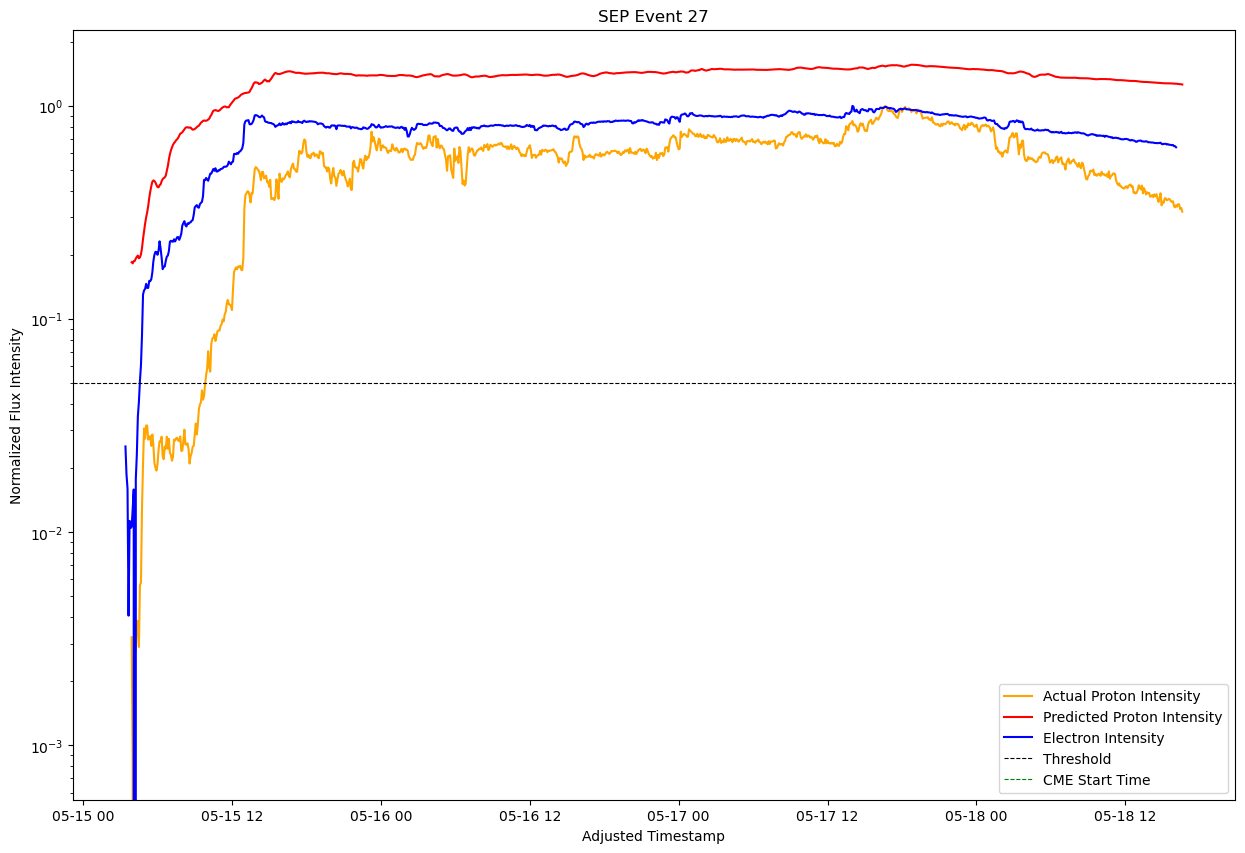

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\SEP_Event_27_MAE_0.7774.png
Processed file: sep_event_27_filled_ie.csv with MAE: 0.7773605743299349


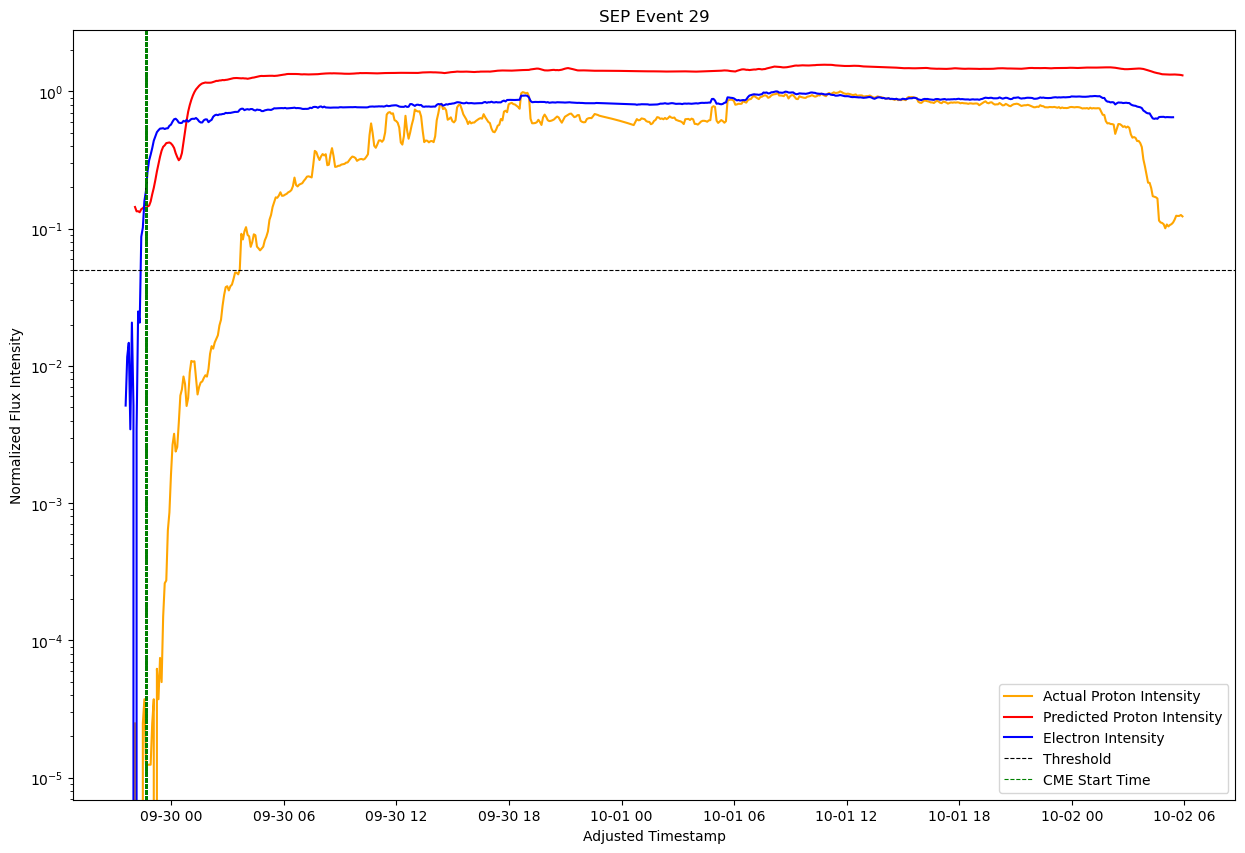

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\SEP_Event_29_MAE_0.7785.png
Processed file: sep_event_29_filled_ie.csv with MAE: 0.7785181540911482


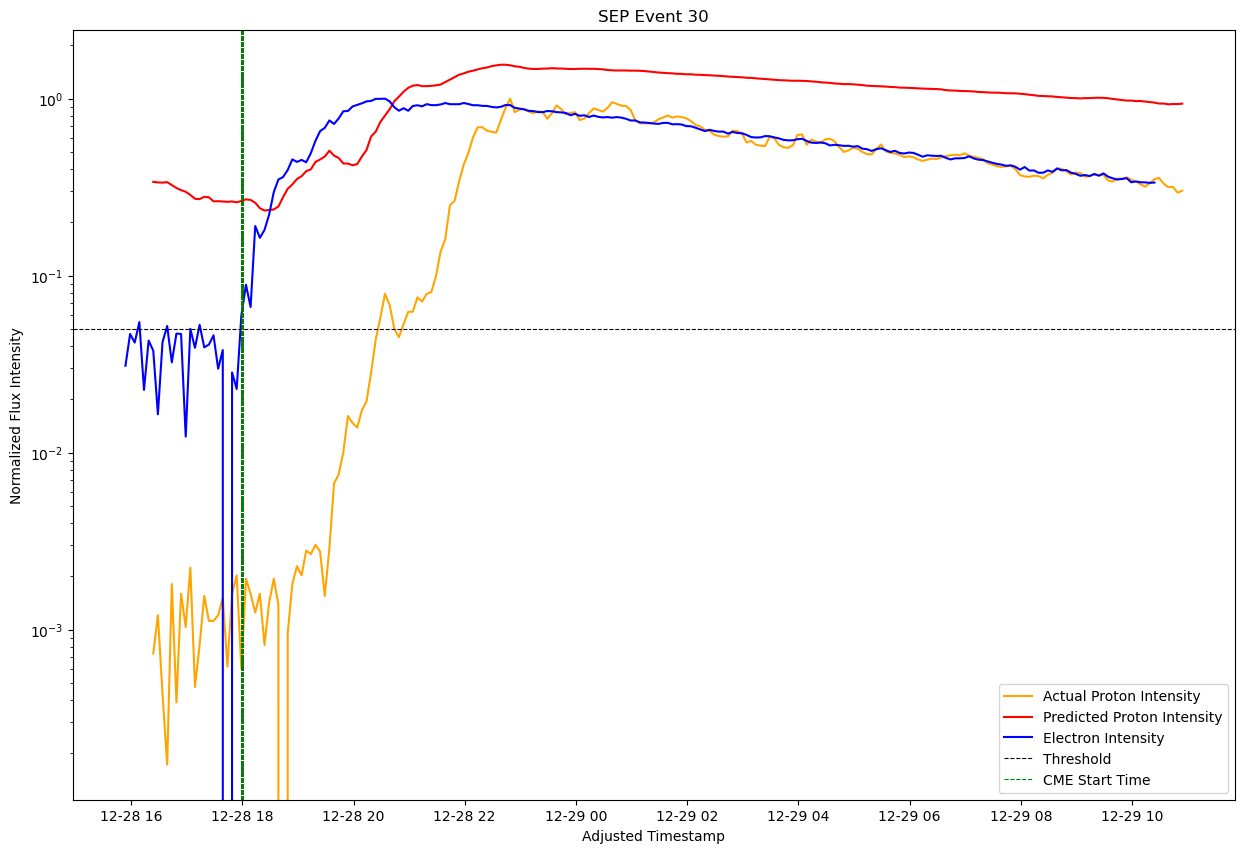

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\SEP_Event_30_MAE_0.6217.png
Processed file: sep_event_30_filled_ie.csv with MAE: 0.6217466356725263


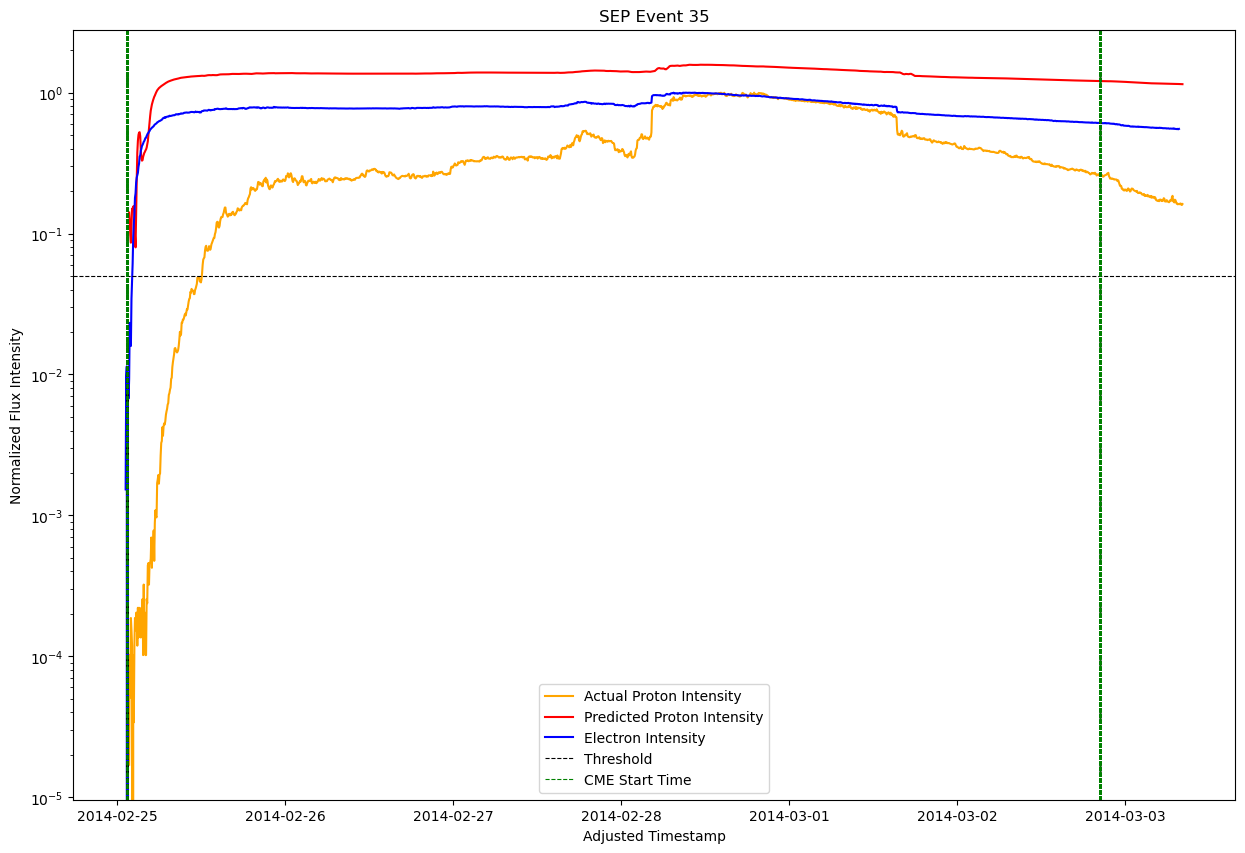

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\SEP_Event_35_MAE_0.9205.png
Processed file: sep_event_35_filled_ie.csv with MAE: 0.9205284689928369


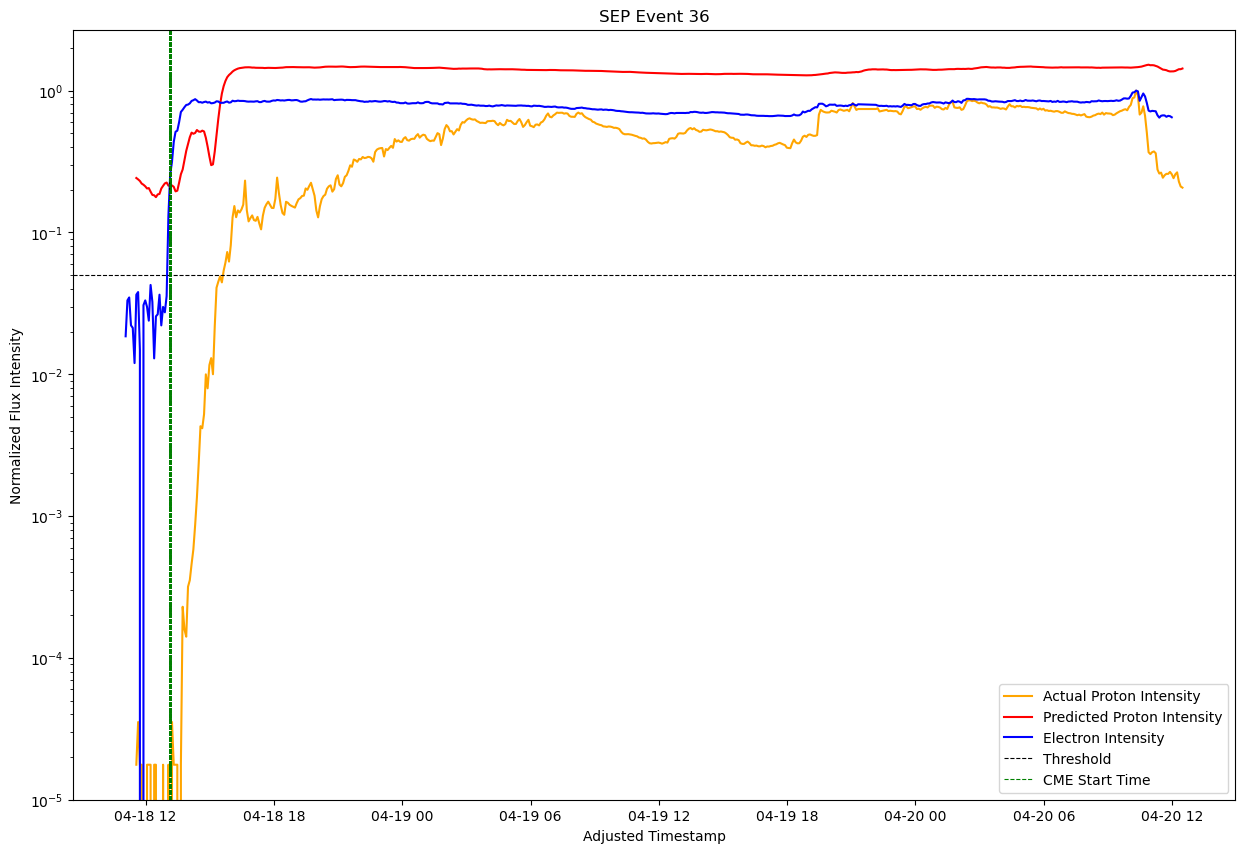

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\SEP_Event_36_MAE_0.8253.png
Processed file: sep_event_36_filled_ie.csv with MAE: 0.8252845255114786


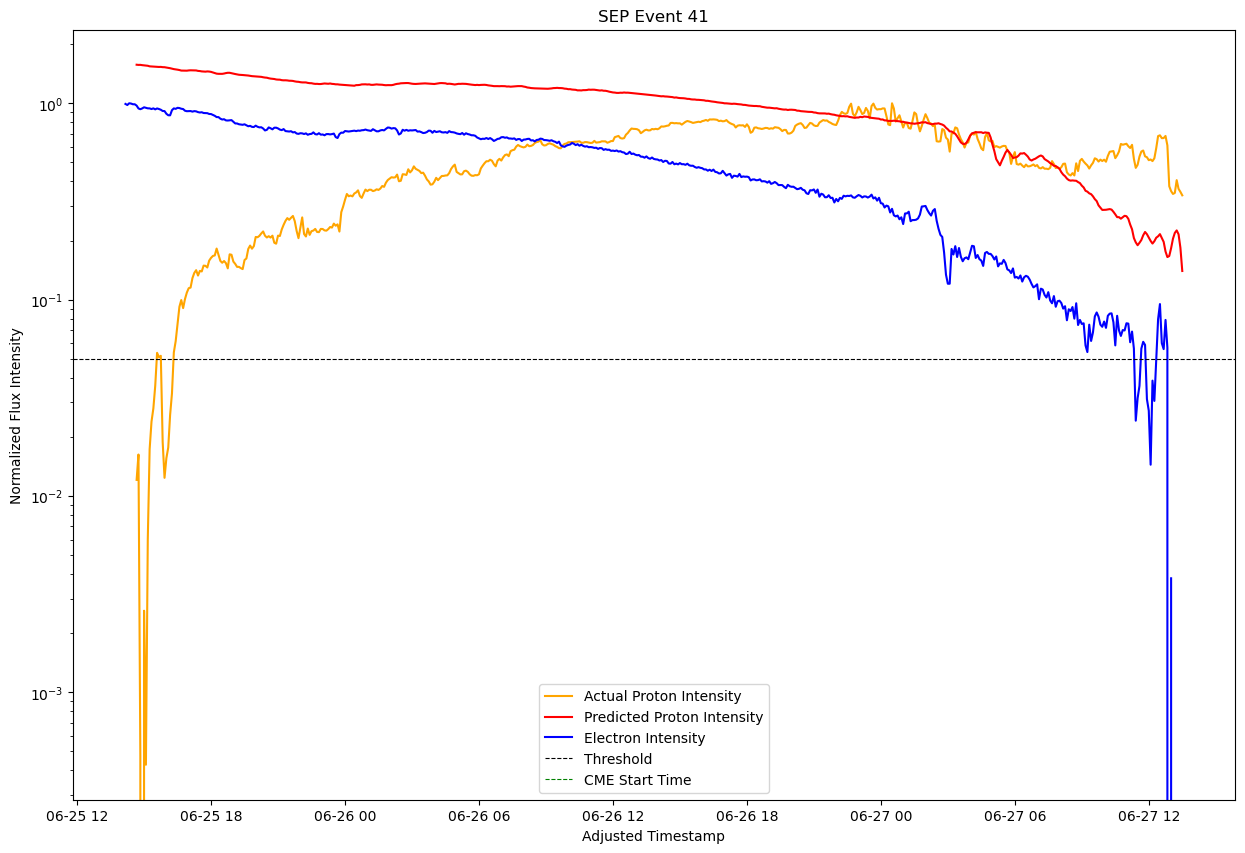

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\SEP_Event_41_MAE_0.5225.png
Processed file: sep_event_41_filled_ie.csv with MAE: 0.5224690798517689


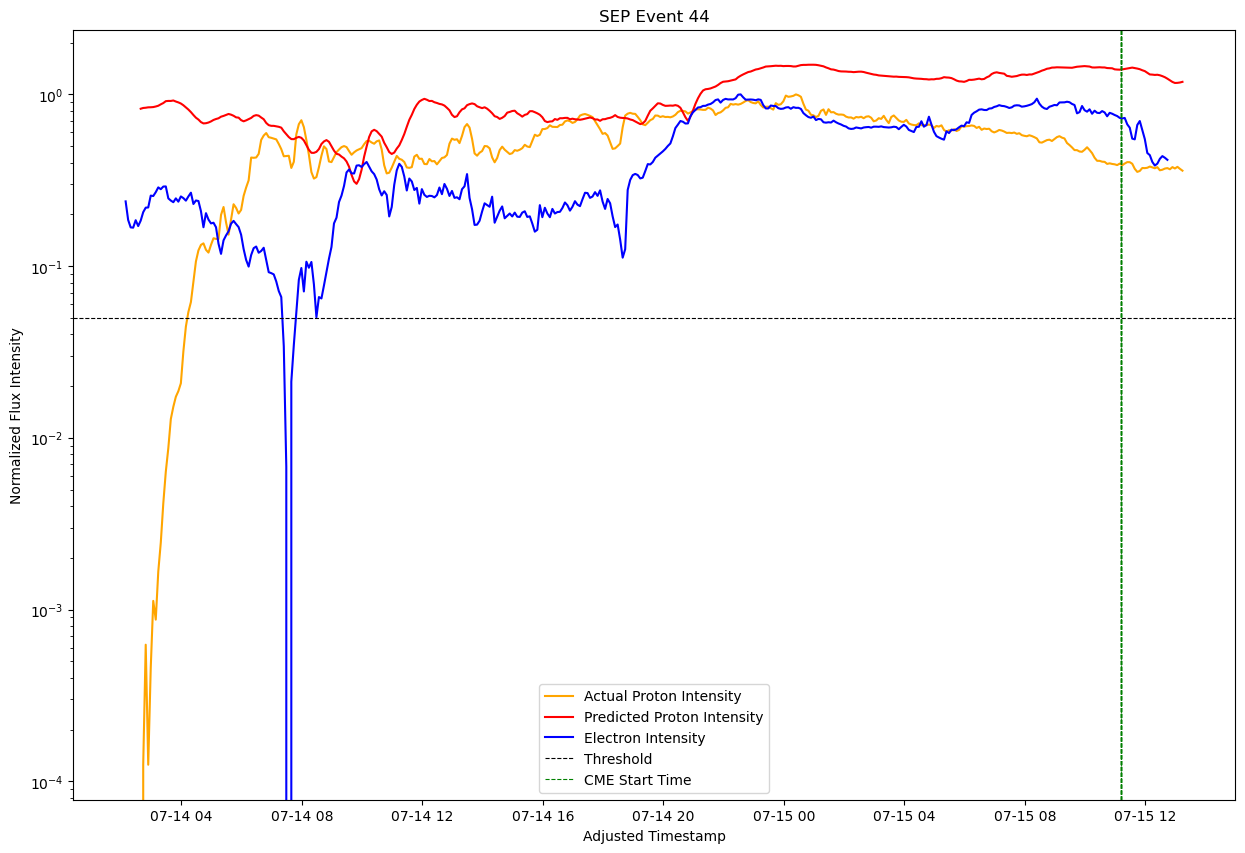

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\SEP_Event_44_MAE_0.4614.png
Processed file: sep_event_44_filled_ie.csv with MAE: 0.46138974348787787


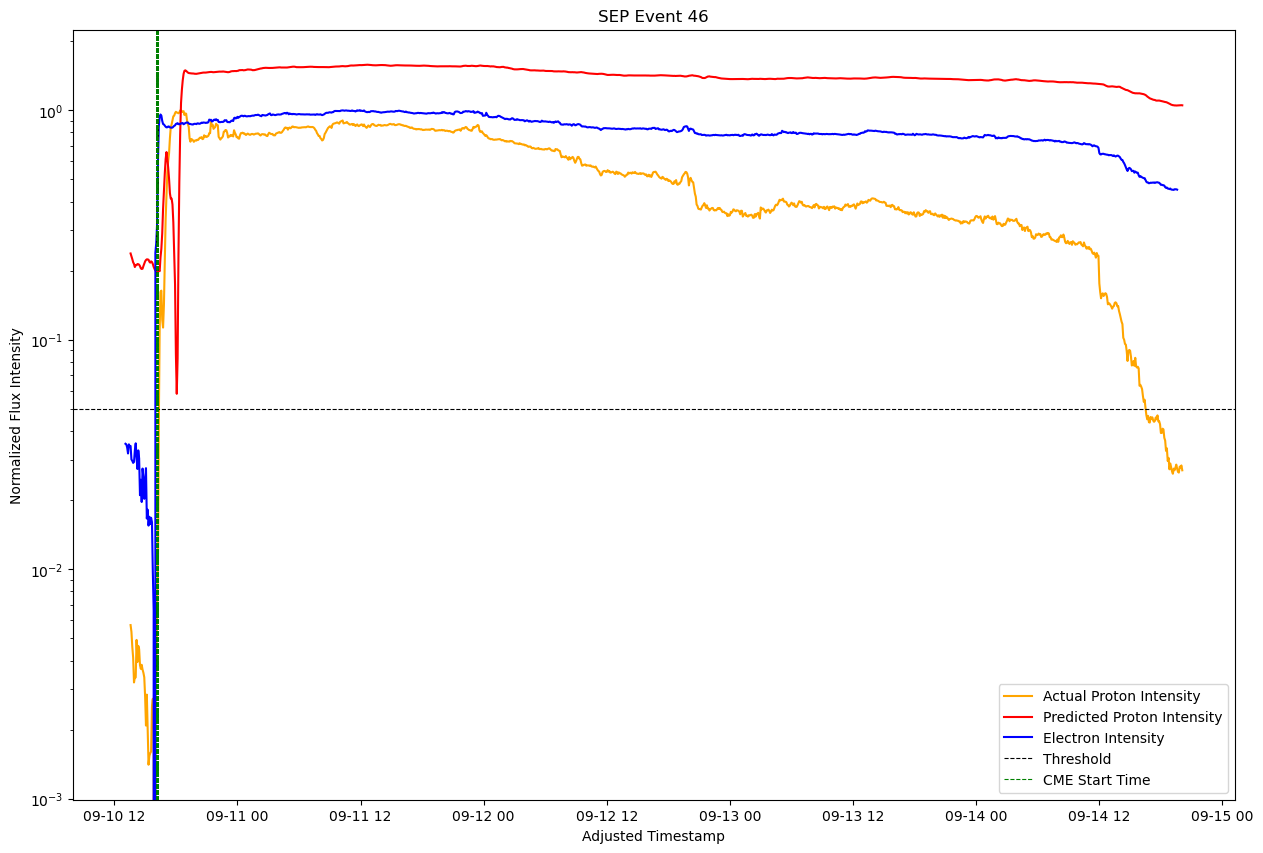

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\SEP_Event_46_MAE_0.8669.png
Processed file: sep_event_46_filled_ie.csv with MAE: 0.8668636425048484


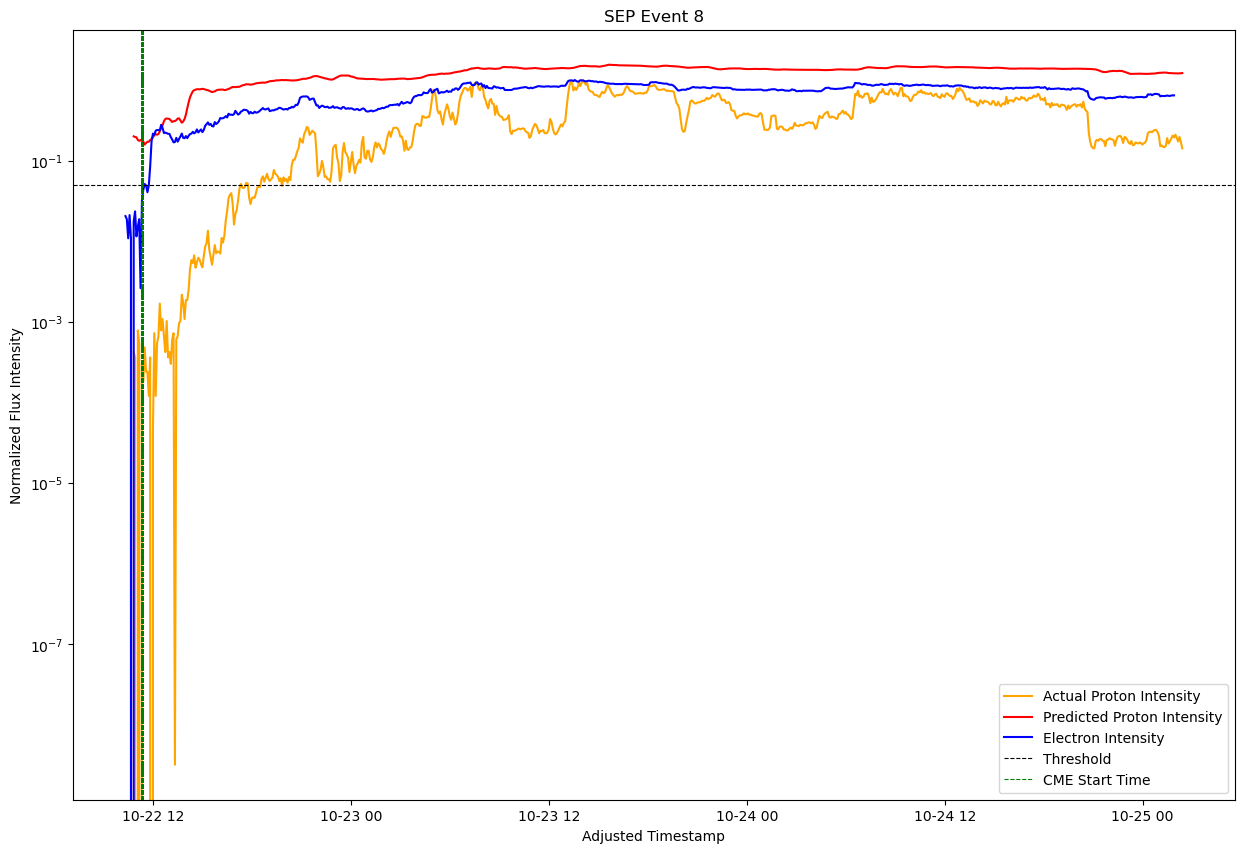

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\SEP_Event_8_MAE_0.8574.png
Processed file: sep_event_8_filled_ie.csv with MAE: 0.857444056201914


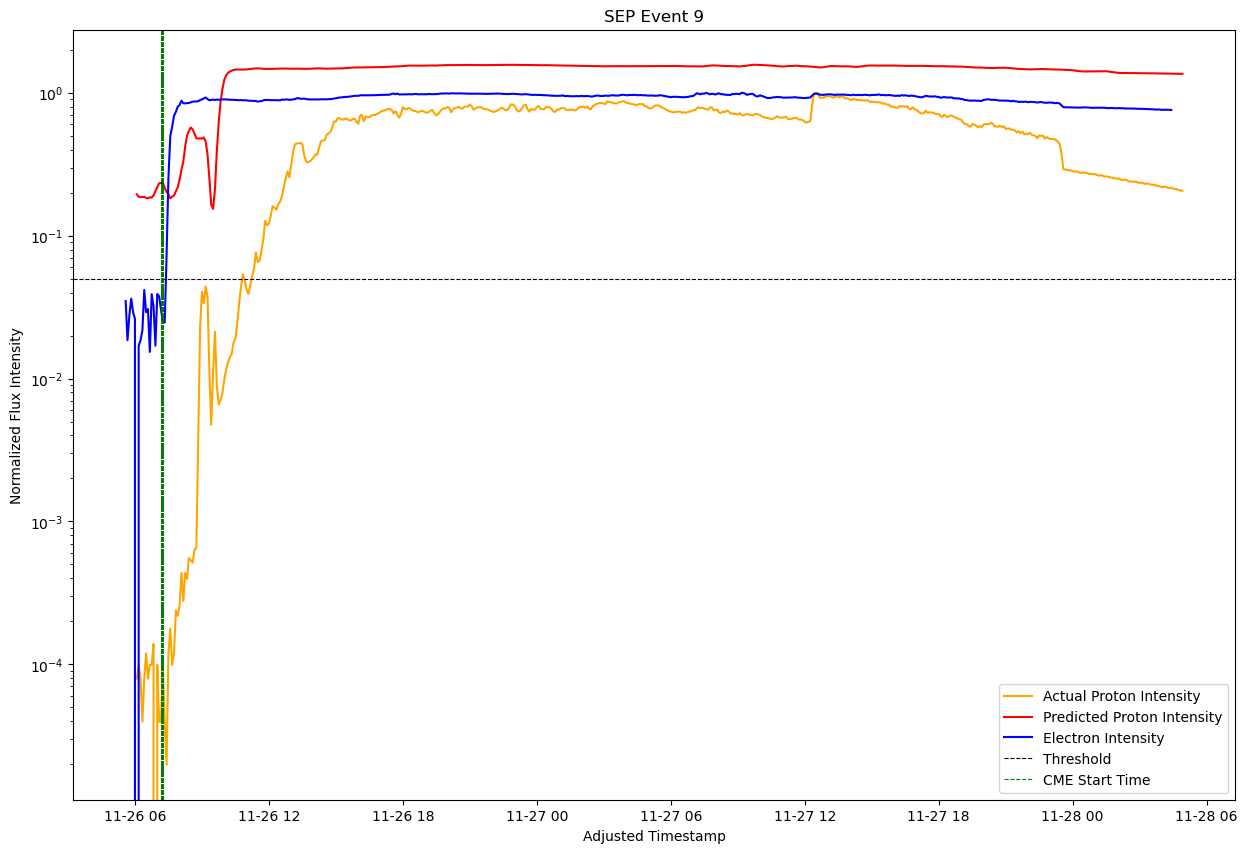

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\SEP_Event_9_MAE_0.8440.png
Processed file: sep_event_9_filled_ie.csv with MAE: 0.844003491735534


In [56]:
# Process SEP event files in the specified directory
test_directory = 'D:/College/Fall2023/electron_cme_data_split/testing'
process_sep_events(test_directory, final_model_sep)